<a href="https://colab.research.google.com/github/doogzultz/time_series_project/blob/main/model_test_simple_and_classical.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from pandas.plotting import scatter_matrix
from tensorflow.keras.layers import Layer, Dense, Dropout, Input, \
Flatten, Concatenate, Conv1D, LSTM, Bidirectional, BatchNormalization, Activation, TimeDistributed, Lambda, MaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.keras.backend as K
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.utils import shuffle
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import GridSearchCV, train_test_split, ParameterGrid
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer, mean_absolute_percentage_error
import os

In [ ]:
class g:
  batch_size = 32
  valid_cut = '2011-10-01'
  test_cut = '2011-11-01'
  test = False
  drop_extra_factors = True
  smape_threshold = .5
  smape_epsilon = 1e-3
  window_size = 16

In [ ]:
url = "https://raw.githubusercontent.com/doogzultz/time_series_project/main/data.csv"
data = pd.read_csv(url)

In [ ]:
data.columns

Index(['date', 'identifier', 'market_cap', 'sector', 'index_membership',
       'factor_1', 'factor_2', 'factor_3', 'factor_4', 'factor_5', 'factor_6',
       'factor_7', 'factor_8', 'factor_9', 'factor_10', 'target'],
      dtype='object')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32202 entries, 0 to 32201
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   date              32202 non-null  object 
 1   identifier        32202 non-null  object 
 2   market_cap        32202 non-null  float64
 3   sector            32202 non-null  int64  
 4   index_membership  32202 non-null  bool   
 5   factor_1          32202 non-null  float64
 6   factor_2          32202 non-null  float64
 7   factor_3          32202 non-null  float64
 8   factor_4          32202 non-null  float64
 9   factor_5          32202 non-null  float64
 10  factor_6          32202 non-null  float64
 11  factor_7          32202 non-null  float64
 12  factor_8          32202 non-null  float64
 13  factor_9          32202 non-null  float64
 14  factor_10         32202 non-null  float64
 15  target            32202 non-null  float64
dtypes: bool(1), float64(12), int64(1), objec

In [ ]:
data.drop(columns = 'index_membership', inplace = True)

In [ ]:
data.sort_values(by = ['identifier', 'date'], inplace = True)
data

,date,identifier,market_cap,sector,factor_1,factor_2,factor_3,factor_4,factor_5,factor_6,factor_7,factor_8,factor_9,factor_10,target
82,2010-01-06,AD41WBQFVG43,5.843968e+10,35,0.766639,-0.000032,0.832677,0.500608,0.193489,0.246089,0.753702,0.792736,-0.000005,0.109029,-0.000006
400,2010-01-13,AD41WBQFVG43,4.758865e+10,35,0.907349,-0.022933,0.346457,0.581694,0.648483,0.872304,0.723412,0.333230,-0.009504,0.121348,-0.008721
718,2010-01-20,AD41WBQFVG43,3.374757e+10,35,0.476465,-0.000114,0.592328,0.379747,0.810961,0.017737,0.619208,0.058918,-0.000099,0.890898,-0.000081
1036,2010-01-27,AD41WBQFVG43,4.908395e+10,35,0.265141,-0.000034,0.521405,0.682492,0.547349,0.155915,0.068966,0.699718,-0.000037,0.355059,-0.000018
1354,2010-02-03,AD41WBQFVG43,2.729189e+10,35,0.423987,0.000197,0.950500,0.628533,0.956287,0.426634,0.752799,0.961276,0.000163,0.196711,0.000318
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12552,2010-10-06,ZMYXRS4KVOG2,6.504496e+08,25,0.069622,0.009936,0.588354,0.447469,0.353549,0.767779,0.790632,0.308049,0.012255,0.281193,0.005117
12862,2010-10-13,ZMYXRS4KVOG2,1.403710e+09,25,0.343444,0.002566,0.394802,0.143162,0.116762,0.744089,0.825323,0.559633,0.001058,0.755124,0.000446
13172,2010-10-20,ZMYXRS4KVOG2,7.284687e+08,25,0.857557,0.000146,0.892729,0.113346,0.574870,0.990100,0.319424,0.591153,0.000054,0.933679,0.000035
13483,2010-10-27,ZMYXRS4KVOG2,7.766592e+08,25,0.093894,-0.000885,0.311392,0.768537,0.589851,0.289180,0.431484,0.373209,-0.000411,0.225972,-0.000242


In [ ]:
(data== 0).sum(axis=0)

date           0
identifier     0
market_cap     0
sector         0
factor_1       0
factor_2      68
factor_3       0
factor_4       0
factor_5       0
factor_6       0
factor_7       0
factor_8       0
factor_9      68
factor_10      0
target        68
dtype: int64

In [ ]:
ident_counts= data.value_counts('identifier')
ident_counts

identifier
AD41WBQFVG43    104
UZ4DWDZ8ALZ4    104
KR47536Y10D4    104
KPJ8FTV9ESJ3    104
KMHQ727PU8E2    104
               ... 
PNUM57CYEB27      5
KHKNKSMXBWP3      5
LYCPQJ19AOY0      5
RENR64FT3I74      5
LALJLSN9UMP2      2
Length: 356, dtype: int64

In [ ]:
print(np.arange(0, 104, 103))

[  0 103]


([], <a list of 0 Text major ticklabel objects>)

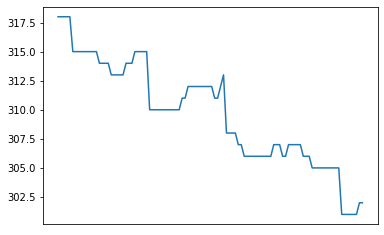

In [ ]:
plt.plot(data.value_counts('date').sort_index())
plt.xticks([])

In [ ]:
data = data.astype({'date':np.datetime64})

In [ ]:
data.value_counts('sector', normalize = True).sort_index()

sector
10    0.049221
15    0.093162
20    0.208527
25    0.132849
30    0.072759
35    0.049003
40    0.232812
45    0.051674
50    0.038352
55    0.071642
dtype: float64

In [ ]:
data[data['date']<'2011-10-01'].value_counts('sector', normalize = True).sort_index()

sector
10    0.049103
15    0.093537
20    0.207769
25    0.133689
30    0.071568
35    0.049386
40    0.234231
45    0.051509
50    0.037712
55    0.071497
dtype: float64

In [ ]:
data[data['date']>'2011-10-01'].value_counts('sector', normalize = True).sort_index()

sector
10    0.050064
15    0.090470
20    0.213977
25    0.126811
30    0.081321
35    0.046252
40    0.222618
45    0.052859
50    0.042948
55    0.072681
dtype: float64

In [ ]:
sector_onehot = pd.get_dummies(data['sector'], prefix='sector')
#ident_onehot = pd.get_dummies(data['identifier'], prefix='ident')
#ident_onehot.head()

In [ ]:
target = data['target']
data.drop(columns = ['sector', 'target'], inplace = True)
data = pd.concat([data, sector_onehot, target], axis = 1)
data.columns

Index(['date', 'identifier', 'market_cap', 'factor_1', 'factor_2', 'factor_3',
       'factor_4', 'factor_5', 'factor_6', 'factor_7', 'factor_8', 'factor_9',
       'factor_10', 'sector_10', 'sector_15', 'sector_20', 'sector_25',
       'sector_30', 'sector_35', 'sector_40', 'sector_45', 'sector_50',
       'sector_55', 'target'],
      dtype='object')

In [ ]:
def split_to_series(df,valid_cut = g.valid_cut, test = g.test, test_cut= g.test_cut, drop_non_complete = False):
  series_dict = {}
  train_dict = {}
  valid_dict = {}
  test_dict = {0: pd.DataFrame(columns = data.columns)} #empty dataframe in case we want a test split as well
  for i, ident in enumerate(df.value_counts('identifier').index):
    #first we separate by identifier and index by date
    if df[df['identifier'] == ident].shape[0]<104 and drop_non_complete == True:
      continue
    series_dict[i] = df[df['identifier'] == ident].set_index('date', verify_integrity= True).sort_index()
    if test == True:
      #see below for explanation
      train_dict[i] = series_dict[i].loc[:valid_cut]
      valid_dict[i] = series_dict[i].loc[valid_cut:test_cut]
      test_dict[i] = series_dict[i].loc[test_cut:]
    else:
      #separate each series into train and validation sets, where we cut by valid_cut and
      #add the data after valid_cut to validation
      train_dict[i] = series_dict[i].loc[:valid_cut]
      valid_dict[i] = series_dict[i].loc[valid_cut:] #could be empty

  #Finally, we calculate the train split size in terms of series and time steps    
  print(f"Number of series to be trained: {len([key for key, value in train_dict.items() if value.shape[0]>0])}")
  print(f"Number of time series to be validated: {len([key for key, value in valid_dict.items() if value.shape[0]>0])}")
  print(f"Number of time series to be tested: {len([key for key, value in test_dict.items() if value.shape[0]>0])}")
  train_length = sum([value.shape[0] for key, value in train_dict.items()])
  valid_length = sum([value.shape[0] for key, value in valid_dict.items()])
  test_length = sum([value.shape[0] for key, value in test_dict.items()])
  
  print(f"Number of time steps to be trained: {train_length}")
  print(f"Number of time steps to be validated: {valid_length}")
  print(f"Number of time series to be tested: {test_length}")
  print(f"Train_proportion: {train_length/(train_length+valid_length+test_length)}")

  return train_dict, valid_dict, test_dict

In [ ]:
train_dict, valid_dict, test_dict = split_to_series(data)

Number of series to be trained: 349
Number of time series to be validated: 313
Number of time series to be tested: 0
Number of time steps to be trained: 28267
Number of time steps to be validated: 3935
Number of time series to be tested: 0
Train_proportion: 0.8778026209552202


In [ ]:
train_dict[0].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 91 entries, 2010-01-06 to 2011-09-28
Data columns (total 23 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   identifier  91 non-null     object 
 1   market_cap  91 non-null     float64
 2   factor_1    91 non-null     float64
 3   factor_2    91 non-null     float64
 4   factor_3    91 non-null     float64
 5   factor_4    91 non-null     float64
 6   factor_5    91 non-null     float64
 7   factor_6    91 non-null     float64
 8   factor_7    91 non-null     float64
 9   factor_8    91 non-null     float64
 10  factor_9    91 non-null     float64
 11  factor_10   91 non-null     float64
 12  sector_10   91 non-null     uint8  
 13  sector_15   91 non-null     uint8  
 14  sector_20   91 non-null     uint8  
 15  sector_25   91 non-null     uint8  
 16  sector_30   91 non-null     uint8  
 17  sector_35   91 non-null     uint8  
 18  sector_40   91 non-null     uint8  
 19  sector_45  

In [ ]:
valid_dict[0].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13 entries, 2011-10-05 to 2011-12-28
Data columns (total 23 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   identifier  13 non-null     object 
 1   market_cap  13 non-null     float64
 2   factor_1    13 non-null     float64
 3   factor_2    13 non-null     float64
 4   factor_3    13 non-null     float64
 5   factor_4    13 non-null     float64
 6   factor_5    13 non-null     float64
 7   factor_6    13 non-null     float64
 8   factor_7    13 non-null     float64
 9   factor_8    13 non-null     float64
 10  factor_9    13 non-null     float64
 11  factor_10   13 non-null     float64
 12  sector_10   13 non-null     uint8  
 13  sector_15   13 non-null     uint8  
 14  sector_20   13 non-null     uint8  
 15  sector_25   13 non-null     uint8  
 16  sector_30   13 non-null     uint8  
 17  sector_35   13 non-null     uint8  
 18  sector_40   13 non-null     uint8  
 19  sector_45  

In [ ]:
test_dict[0].info()

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 24 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   date        0 non-null      object
 1   identifier  0 non-null      object
 2   market_cap  0 non-null      object
 3   factor_1    0 non-null      object
 4   factor_2    0 non-null      object
 5   factor_3    0 non-null      object
 6   factor_4    0 non-null      object
 7   factor_5    0 non-null      object
 8   factor_6    0 non-null      object
 9   factor_7    0 non-null      object
 10  factor_8    0 non-null      object
 11  factor_9    0 non-null      object
 12  factor_10   0 non-null      object
 13  sector_10   0 non-null      object
 14  sector_15   0 non-null      object
 15  sector_20   0 non-null      object
 16  sector_25   0 non-null      object
 17  sector_30   0 non-null      object
 18  sector_35   0 non-null      object
 19  sector_40   0 non-null      object
 20  sector_45   0 non-null     

In [ ]:
numerical_features = ['market_cap']+list(data.loc[:,'factor_1':'factor_10'].columns)+['target']
numerical_features

['market_cap',
 'factor_1',
 'factor_2',
 'factor_3',
 'factor_4',
 'factor_5',
 'factor_6',
 'factor_7',
 'factor_8',
 'factor_9',
 'factor_10',
 'target']

In [ ]:
train_dict[0].columns

Index(['identifier', 'market_cap', 'factor_1', 'factor_2', 'factor_3',
       'factor_4', 'factor_5', 'factor_6', 'factor_7', 'factor_8', 'factor_9',
       'factor_10', 'sector_10', 'sector_15', 'sector_20', 'sector_25',
       'sector_30', 'sector_35', 'sector_40', 'sector_45', 'sector_50',
       'sector_55', 'target'],
      dtype='object')

In [ ]:
def scale_and_drop_columns(train_dict, valid_dict, test_dict, numerical_features, drop_extra_factors = g.drop_extra_factors):
  train_df = pd.concat(train_dict, ignore_index = True)
  t_mean = np.mean(train_df[numerical_features], axis = 0)
  t_std = np.std(train_df[numerical_features], axis = 0)
  for i in range(0,len(train_dict)):
    train_dict[i][numerical_features] = (train_dict[i][numerical_features]-t_mean)/t_std
    train_dict[i].drop(columns = ['identifier'], inplace = True)
    if drop_extra_factors ==True:
      train_dict[i].drop(columns = ['factor_1', 'factor_3', 'factor_4', 'factor_5', 'factor_6', 
                                    'factor_7', 'factor_8', 'factor_10'], inplace= True)
  for i in range(0,len(valid_dict)):
    valid_dict[i][numerical_features] = (valid_dict[i][numerical_features]-t_mean)/t_std
    valid_dict[i].drop(columns = ['identifier'], inplace = True)
    if drop_extra_factors ==True:
      valid_dict[i].drop(columns = ['factor_1', 'factor_3', 'factor_4', 'factor_5', 'factor_6', 
                                    'factor_7', 'factor_8', 'factor_10'], inplace= True)
  for i in range(0,len(test_dict)):
    test_dict[i][numerical_features] = (test_dict[i][numerical_features]-t_mean)/t_std
    test_dict[i].drop(columns = ['identifier'], inplace = True)
    if drop_extra_factors ==True:
      test_dict[i].drop(columns = ['factor_1', 'factor_3', 'factor_4', 'factor_5', 'factor_6', 
                                    'factor_7', 'factor_8', 'factor_10'], inplace= True)
  return train_dict, valid_dict, test_dict, t_mean, t_std


In [ ]:
train_final, valid_final, test_final, t_mean, t_std= \
scale_and_drop_columns(train_dict, valid_dict, test_dict, numerical_features)

In [ ]:
t_mean, t_std

(market_cap    1.111389e+10
 factor_1      4.985447e-01
 factor_2     -1.913018e-04
 factor_3      5.000637e-01
 factor_4      4.988483e-01
 factor_5      5.005490e-01
 factor_6      5.000944e-01
 factor_7      4.979793e-01
 factor_8      4.986385e-01
 factor_9     -2.047397e-04
 factor_10     4.986891e-01
 target       -2.058015e-04
 dtype: float64, market_cap    1.589832e+10
 factor_1      2.890597e-01
 factor_2      5.703728e-03
 factor_3      2.890388e-01
 factor_4      2.889261e-01
 factor_5      2.891119e-01
 factor_6      2.878230e-01
 factor_7      2.877822e-01
 factor_8      2.890916e-01
 factor_9      5.954812e-03
 factor_10     2.872727e-01
 target        5.718353e-03
 dtype: float64)

In [ ]:
train_final[0].info(), valid_final[0].info(), test_final[0].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 91 entries, 2010-01-06 to 2011-09-28
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   market_cap  91 non-null     float64
 1   factor_2    91 non-null     float64
 2   factor_9    91 non-null     float64
 3   sector_10   91 non-null     uint8  
 4   sector_15   91 non-null     uint8  
 5   sector_20   91 non-null     uint8  
 6   sector_25   91 non-null     uint8  
 7   sector_30   91 non-null     uint8  
 8   sector_35   91 non-null     uint8  
 9   sector_40   91 non-null     uint8  
 10  sector_45   91 non-null     uint8  
 11  sector_50   91 non-null     uint8  
 12  sector_55   91 non-null     uint8  
 13  target      91 non-null     float64
dtypes: float64(4), uint8(10)
memory usage: 4.4 KB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13 entries, 2011-10-05 to 2011-12-28
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  -

(None, None, None)

In [ ]:
def shuffle_and_aggregate(data_dict, shuffle_ = True):
  data_agg = pd.concat(data_dict, axis = 0)
  if shuffle_ == True:
    data_agg = shuffle(data_agg)
  target = data_agg['target']
  data_agg = data_agg.drop(columns = 'target')
  return data_agg, target
    

In [ ]:
x_train, y_train = shuffle_and_aggregate(train_final)
x_valid, y_valid = shuffle_and_aggregate(valid_final, shuffle_= False)
x_test, y_test = shuffle_and_aggregate(test_final, shuffle_=False)
print(x_train.shape, y_train.shape, x_valid.shape, y_valid.shape, x_test.shape, y_test.shape)

(28267, 13) (28267,) (3935, 13) (3935,) (0, 14) (0,)


In [ ]:
def create_mape_np(epsilon = g.smape_epsilon, threshold = g.smape_threshold, mean = True):
  def mape(y_true, y_pred, **kwargs):
      sum_ = np.maximum(np.abs(y_true) + epsilon, threshold+epsilon)
      if mean == False:
        return 100*np.abs(y_pred - y_true) / sum_
      else:
        return -np.mean(100*np.abs(y_pred - y_true) / sum_)
  return mape

In [ ]:
def create_smape_np(epsilon = g.smape_epsilon, threshold = g.smape_threshold, mean = True):
  def smape(y_true, y_pred, **kwargs):
      sum_ = np.maximum(np.abs(y_true) + np.abs(y_pred) + epsilon, threshold+epsilon)
      if mean == False:
        return 100*np.abs(y_pred - y_true) / sum_*2
      else:
        return -np.mean(100*np.abs(y_pred - y_true) / sum_ *2)
  return smape

In [ ]:
smape = create_smape_np()
mape = create_mape_np()
smape_score = make_scorer(create_smape_np(), higher_is_better = False)
mape_score = make_scorer(create_mape_np(), higher_is_better = False)

In [ ]:
def naive_models(valid_scaled, metrics = {'smape':create_smape_np(mean = False), 'mape': create_mape_np(mean = False)}):
  total_smape_0 = 0
  total_smape = 0
  total_smape_3 = 0
  total_mae_0 = 0
  total_mae = 0
  total_mae_3 = 0
  total_mape_0 = 0
  total_mape = 0
  count_0=0
  count = 0
  count_3 = 0
  for i in range(0, len(valid_scaled)):
    total_smape_0 += np.sum(metrics['smape'](np.zeros(valid_scaled[i].shape[0], dtype = np.float32), np.asarray(valid_scaled[i].iloc[:,-1])))
    total_mape_0 += np.sum(metrics['mape'](np.asarray(valid_scaled[i].iloc[:,-1]),np.zeros(valid_scaled[i].shape[0], dtype = np.float32)))
    total_smape += np.sum(metrics['smape'](np.asarray(valid_scaled[i].iloc[1:,-1]), np.asarray(valid_scaled[i].iloc[:-1,-1])))
    total_mape += np.sum(metrics['mape'](np.asarray(valid_scaled[i].iloc[1:,-1]), np.asarray(valid_scaled[i].iloc[:-1,-1])))
    total_smape_3 += np.sum(metrics['smape'](np.asarray(valid_scaled[i].iloc[3:,-1]),
                                             (1/3)*(np.asarray(valid_scaled[i].iloc[:-3,-1])
                                             +np.asarray(valid_scaled[i].iloc[1:-2,-1])
                                             +np.asarray(valid_scaled[i].iloc[2:-1,-1]))))
    total_mae_0 += np.sum(abs(np.zeros(valid_scaled[i].shape[0], dtype = np.float32)-np.asarray(valid_scaled[i].iloc[:,-1])))
    total_mae += np.sum(abs(np.asarray(valid_scaled[i].iloc[1:,-1])-np.asarray(valid_scaled[i].iloc[:-1,-1])))
    total_mae_3 += np.sum(abs(np.asarray(valid_scaled[i].iloc[3:,-1])-(1/3)*(np.asarray(valid_scaled[i].iloc[:-3,-1])
                                                                          +np.asarray(valid_scaled[i].iloc[1:-2,-1])
                                                                          +np.asarray(valid_scaled[i].iloc[2:-1,-1]))))
    count_0+=valid_scaled[i]['target'].shape[0]
    count += valid_scaled[i]['target'].shape[0]-1
    count_3 += valid_scaled[i]['target'].shape[0]-3
  print(f"Predicting with the mean (zero) gives a SMAPE of {total_smape_0/count_0} \
and an MAE of {total_mae_0/count_0} on the validation set")
  print(f"Predicting with last value gives a SMAPE of {total_smape/count} \
and an MAE of {total_mae/count} on the validation set")
  
  print(f"Predicting with avererage of the last 3 values gives a SMAPE of {total_smape_3/count_3} \
and an MAE of {total_mae_3/count_3} on the validation set")
  print(f"Predicting with the mean (zero) gives a MAPE of {total_mape_0/count_0} \
on the validation set")
  print(f"Predicting with last value gives a MAPE of {total_mape/count} \
on the validation set")
  return

naive_models(valid_final)

Predicting with the mean (zero) gives a SMAPE of 74.29249034332261 and an MAE of 0.4463291212698763 on the validation set
Predicting with last value gives a SMAPE of 94.52783604798606 and an MAE of 0.7192965172811336 on the validation set
Predicting with avererage of the last 3 values gives a SMAPE of 104.34524237649858 and an MAE of 0.6819543146216057 on the validation set
Predicting with the mean (zero) gives a MAPE of 37.146245171661306 on the validation set
Predicting with last value gives a MAPE of 93.87831726302406 on the validation set


In [ ]:
poly = PolynomialFeatures(degree = 1)
poly_train = poly.fit_transform(x_train)
poly_valid = poly.transform(x_valid)
lin_reg = LinearRegression()
lin_reg.fit(poly_train, y_train)
mean_absolute_error(lin_reg.predict(poly_valid), y_valid), smape(lin_reg.predict(poly_valid), y_valid), mape(y_valid, lin_reg.predict(poly_valid))

(0.2466591729495039, -32.38065740919387, -24.9554543062261)

In [ ]:
def model_cv(model, parameters, x_train, y_train, x_valid, y_valid, scoring = smape_score, refit = 'smape', verbose = False):
  model = GridSearchCV(model, param_grid=parameters, scoring = scoring, refit = refit, cv = 3)
  model.fit(x_train, y_train)
  performance = model.score(x_valid, y_valid)
  if verbose ==False:
    return print(f'{model.best_params_}\n cv_score = {model.best_score_}\n valid_score = {performance}')
  else:
    return print(f'{model.best_params_}\n cv_score = {model.best_score_}\n valid_score = {performance}\n'), pd.DataFrame(model.cv_results_).sort_values('mean_test_score')

In [ ]:
# randforest = RandomForestRegressor(n_jobs = -1, random_state = 7)
# parameters = {#'n_estimators':[50, 100, 200], 
#               'max_depth': [6,8,10],
#      #'min_samples_split': [2,4,6],
#      'min_samples_leaf': [8,10,15 ],
#      #'criterion' :['absolute_error', 'squared_error']
#      }
# model_cv(randforest, parameters, x_train, y_train, x_valid, y_valid, verbose = True)

In [ ]:
randforest_test = RandomForestRegressor(n_jobs = -1, random_state = 8, n_estimators = 200, max_depth = 8, min_samples_leaf = 15)
randforest_test.fit(x_train, y_train)
y_pred = randforest_test.predict(x_valid)
mean_absolute_error(y_pred, y_valid), smape(y_pred, y_valid), mape(y_valid,y_pred)


(0.24920772566798866, -31.55397967609133, -26.70829688871777)

In [ ]:
import xgboost
xgb_reg = xgboost.XGBRegressor(n_jobs = -1, learning_rate = .1)
xgb_reg.fit(np.asarray(x_train), np.asarray(y_train), 
            eval_set = [(np.asarray(x_valid), np.asarray(y_valid))],
                         early_stopping_rounds = 10, eval_metric = 'mae')

[11:01:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:0.660009
Will train until validation_0-mae hasn't improved in 10 rounds.
[1]	validation_0-mae:0.60882
[2]	validation_0-mae:0.563874
[3]	validation_0-mae:0.524326
[4]	validation_0-mae:0.490287
[5]	validation_0-mae:0.458574
[6]	validation_0-mae:0.431264
[7]	validation_0-mae:0.408884
[8]	validation_0-mae:0.38844
[9]	validation_0-mae:0.371482
[10]	validation_0-mae:0.354021
[11]	validation_0-mae:0.33908
[12]	validation_0-mae:0.328018
[13]	validation_0-mae:0.31875
[14]	validation_0-mae:0.308731
[15]	validation_0-mae:0.30016
[16]	validation_0-mae:0.293665
[17]	validation_0-mae:0.286394
[18]	validation_0-mae:0.2809
[19]	validation_0-mae:0.276882
[20]	validation_0-mae:0.273132
[21]	validation_0-mae:0.270276
[22]	validation_0-mae:0.267482
[23]	validation_0-mae:0.264521
[24]	validation_0-mae:0.261793
[25]	validation_0-mae:0.259526
[26]	validation_0-ma

XGBRegressor(n_jobs=-1)

In [ ]:
smape = create_smape_np(mean = True)
mape = create_mape_np(mean = True)

In [ ]:
y_pred =xgb_reg.predict(np.asarray(x_valid))
mean_absolute_percentage_error(np.asarray(y_valid), y_pred), smape(np.asarray(y_valid), y_pred), mape(np.asarray(y_valid), y_pred)

(2.9319531073843907, -32.13427430270625, -25.65860291297457)

In [ ]:
def create_smape(epsilon = g.smape_epsilon, threshold = g.smape_threshold):
  def smape(y_true, y_pred):
      summ = K.maximum(K.abs(y_true) + K.abs(y_pred)+epsilon, threshold + epsilon)
      return 100*K.abs(y_pred - y_true) / summ *2
  return smape

In [ ]:
def create_mape(epsilon = g.smape_epsilon, threshold = g.smape_threshold):
  def mape(y_true, y_pred):
      summ = K.maximum(K.abs(y_true)+epsilon, threshold + epsilon)
      return 100*K.abs(y_pred - y_true) / summ
  return mape

In [ ]:
def plot_model_perf(history, metric = None):
  plt.subplots(len([metric]), 1, figsize=(12, 8))
  epochs = range(len(history.history['loss']))
  plt.plot( epochs, history.history['loss'],color = 'blue', label = 'loss' )
  plt.plot(epochs, history.history['val_loss'], color = 'red', label = 'val_loss' )
  plt.legend()
  plt.show()
  if metric:
    for i, metric in enumerate(metric):
      plt.figure(figsize=(12, 8))
      plt.plot( epochs, history.history[f'{metric}'],color = 'green', label = f'{metric}' )
      plt.plot(epochs, history.history[f'val_{metric}'], color = 'orange', label = f'val_{metric}' )
      plt.legend()
      plt.show()

In [ ]:
def dense_block(input_, dense_units, dr):
    lrelu= tf.keras.layers.LeakyReLU()
    x = Dense(dense_units, kernel_initializer="he_normal", kernel_regularizer='l2'
              )(input_)
    x = Dropout(dr)(x)
    #x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dense(dense_units, kernel_initializer="he_normal", kernel_regularizer='l2'
              )(x)
    x = Dropout(dr)(x)
    #x = BatchNormalization()(x)
    out = Activation('relu')(x)
    return out

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 13)]              0         
                                                                 
 dense (Dense)               (None, 64)                896       
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 activation (Activation)     (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 activation_1 (Activation)   (None, 64)                0     

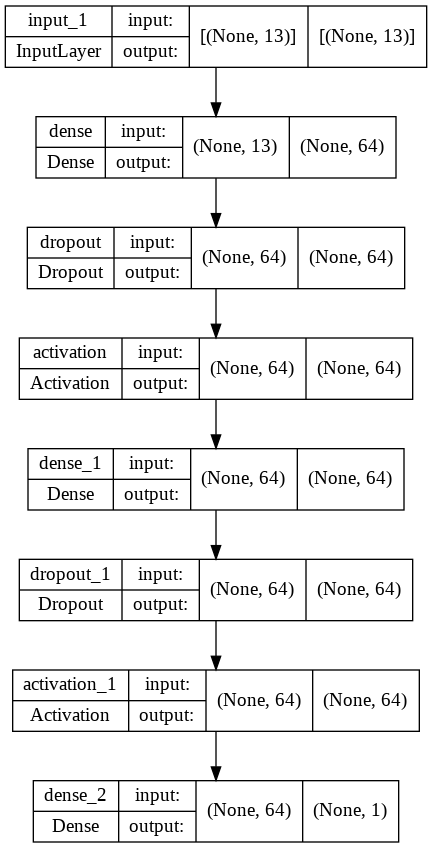

In [ ]:
tf.keras.backend.clear_session()

def create_model(dense_units = 64, dr = .2 ):

    input_ = Input(shape=(x_train.shape[1]))
    x = dense_block(input_, dense_units, dr)
    out = Dense(1)(x)
    model = Model(inputs = input_, outputs = out)
    return model
adam = tf.keras.optimizers.Adam()
model = create_model()
nadam = tf.keras.optimizers.Nadam(learning_rate=.001)
rmsprop = tf.keras.optimizers.RMSprop(learning_rate = .001, momentum=.9)
model.compile(loss = 'mae', optimizer = 'adam', metrics = ['mae', create_mape(),create_smape()])
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
early_stopping = EarlyStopping(patience = 7, restore_best_weights= True)
epochs = 100
lr_tuning = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-5 * 10**((4*epoch)/epochs))



history = model.fit(x_train, y_train, epochs = epochs, validation_data = [x_valid, y_valid],
                    callbacks = [early_stopping], batch_size = g.batch_size)

Epoch 1/100
884/884 [==============================] - 3s 3ms/step - loss: 0.9993 - mae: 0.2512 - mape: 29.3130 - smape: 43.9823 - val_loss: 0.3718 - val_mae: 0.2593 - val_mape: 22.8592 - val_smape: 33.4453
Epoch 2/100
884/884 [==============================] - 2s 2ms/step - loss: 0.2619 - mae: 0.2122 - mape: 22.6635 - smape: 31.9787 - val_loss: 0.2728 - val_mae: 0.2462 - val_mape: 24.2147 - val_smape: 31.9671
Epoch 3/100
884/884 [==============================] - 2s 2ms/step - loss: 0.2323 - mae: 0.2114 - mape: 22.5474 - smape: 31.5074 - val_loss: 0.2692 - val_mae: 0.2515 - val_mape: 23.1633 - val_smape: 32.4054
Epoch 4/100
884/884 [==============================] - 2s 2ms/step - loss: 0.2281 - mae: 0.2108 - mape: 22.5871 - smape: 31.4406 - val_loss: 0.2664 - val_mae: 0.2497 - val_mape: 24.2427 - val_smape: 32.6711
Epoch 5/100
884/884 [==============================] - 2s 2ms/step - loss: 0.2269 - mae: 0.2115 - mape: 22.6779 - smape: 31.6921 - val_loss: 0.2663 - val_mae: 0.2521 - val_

In [ ]:
# lrs = 1e-5 * (10 ** (4*np.arange(epochs) / epochs))

# plt.figure(figsize=(10, 6))
# plt.grid(True)
# plt.semilogx(lrs, history.history["loss"])
# plt.tick_params('both', length=10, width=1, which='both')
# plt.axis([1e-5, 1e-5 * 10**(4), 0, epochs])
# plt.show()

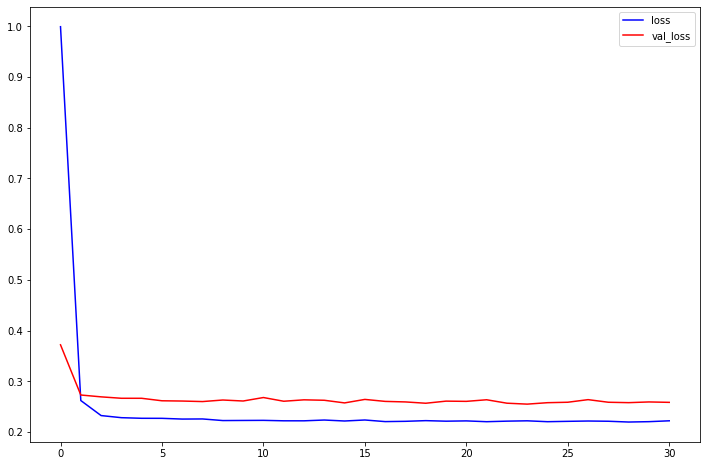

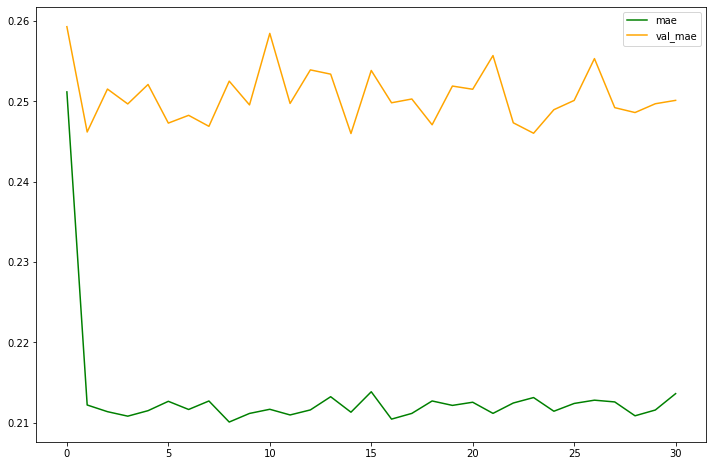

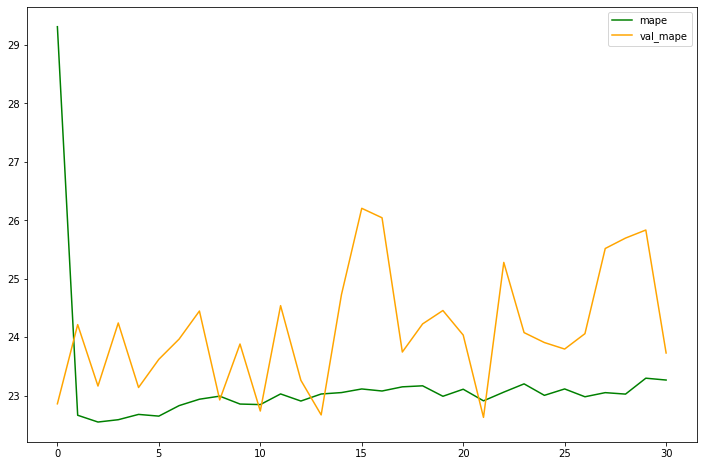

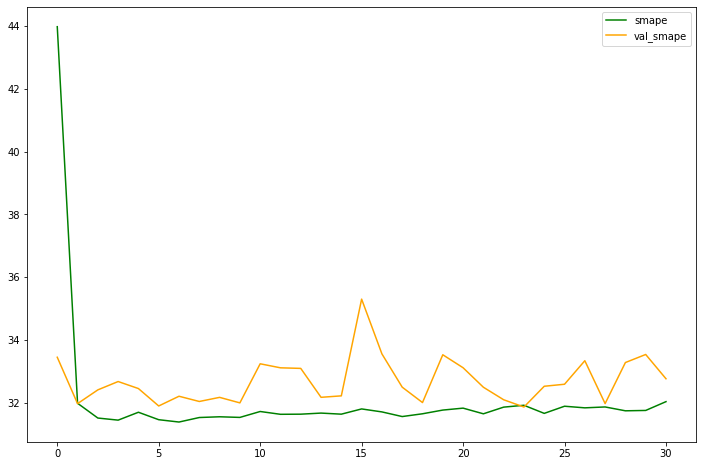

123/123 [==============================] - 0s 2ms/step - loss: 0.2548 - mae: 0.2460 - mape: 24.0777 - smape: 31.8589


[0.25483065843582153,
 0.24601851403713226,
 24.077749252319336,
 31.85887908935547]

In [ ]:
plot_model_perf(history, ['mae','mape','smape'])
model.evaluate(x_valid, y_valid)

In [ ]:
def plot_predictions(data, dict_number, model = model):
  plt.figure(figsize = (20, 8))
  test_batch = data[dict_number].iloc[:,:-1]
  if test_batch.shape[0] == 0:
    return print(f'no data point for validation series {dict_number}')
  targets = data[dict_number].iloc[:,-1].values
  test_pred = model.predict(test_batch)
  plt.plot(data[dict_number].index.values, test_pred.reshape(-1), color = 'red', label = 'Prediction')
  plt.plot(data[dict_number].index.values, targets.reshape(-1), color = 'green', label = 'Actual')
  plt.title(f'Prediction vs. actual for validation series {dict_number}')
  plt.xlabel("Data")
  plt.ylabel("Value")
  plt.legend()
  plt.show()

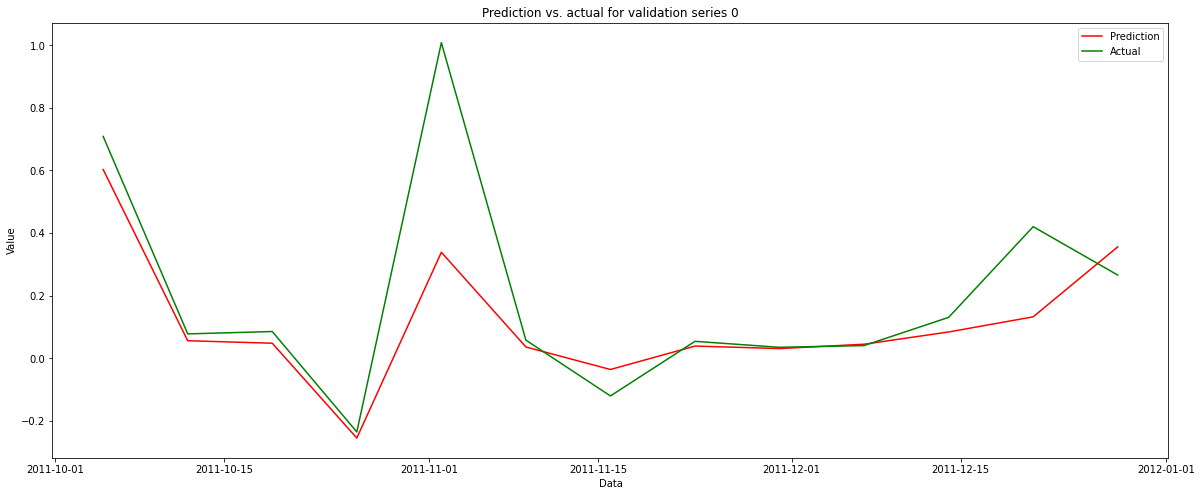

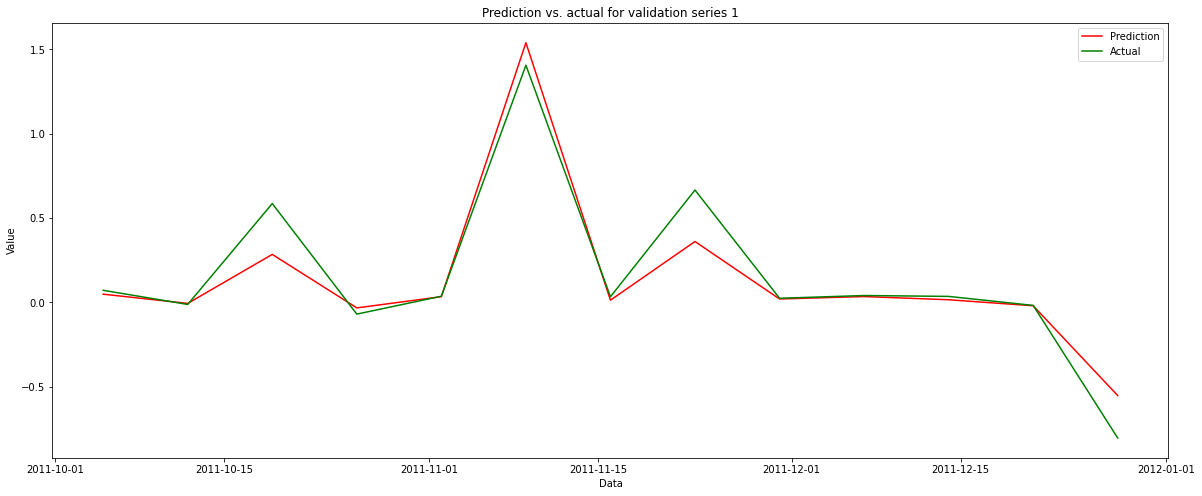

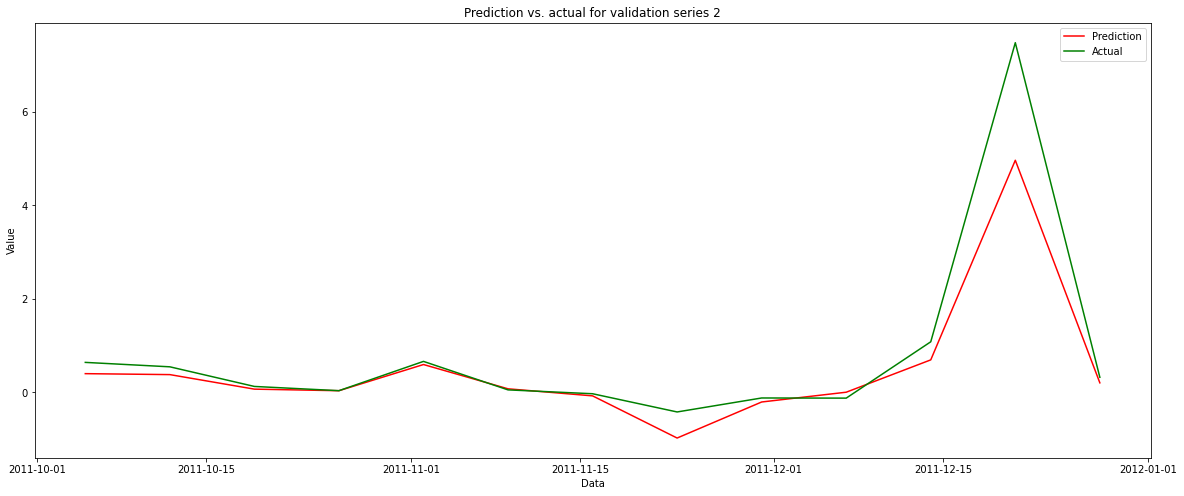

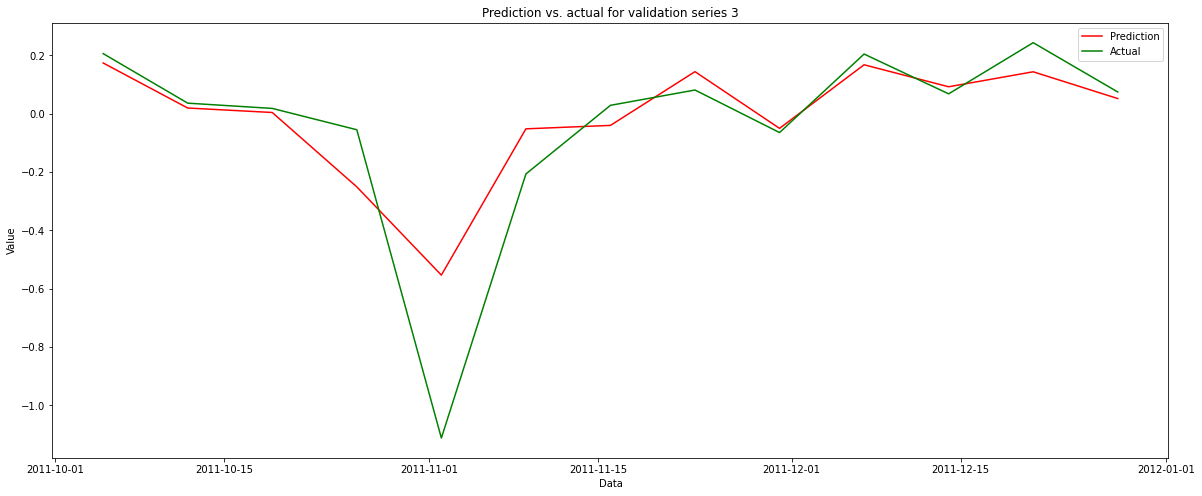

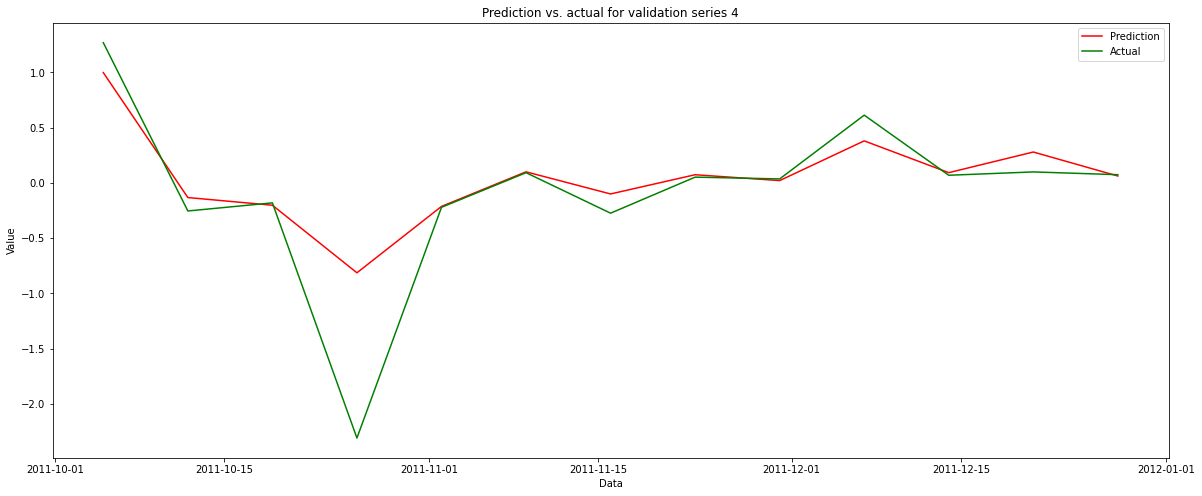

In [ ]:
for i in range(0, 5):
  plot_predictions(valid_final, i)

no data point for validation series 336


<Figure size 1440x576 with 0 Axes>

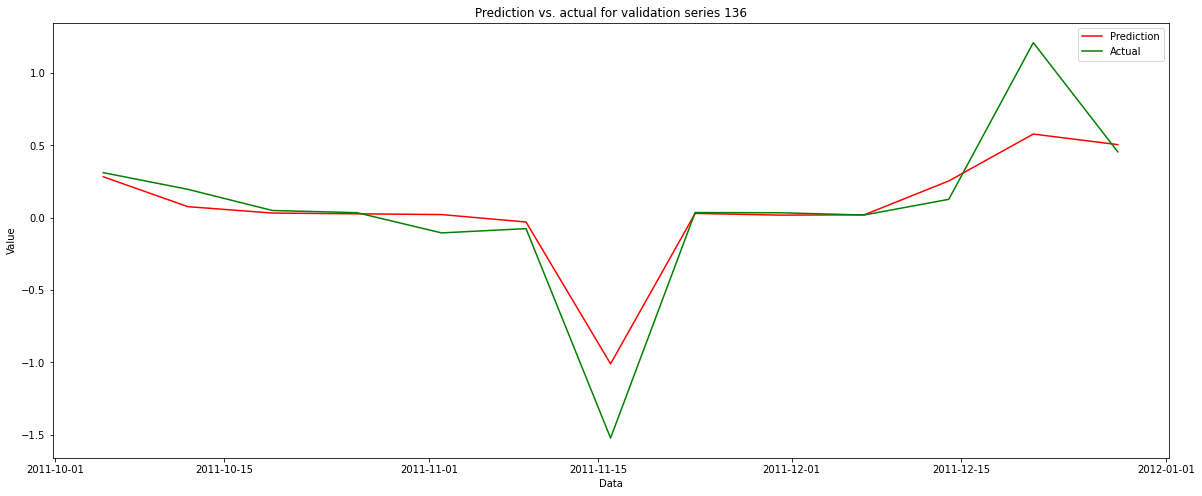

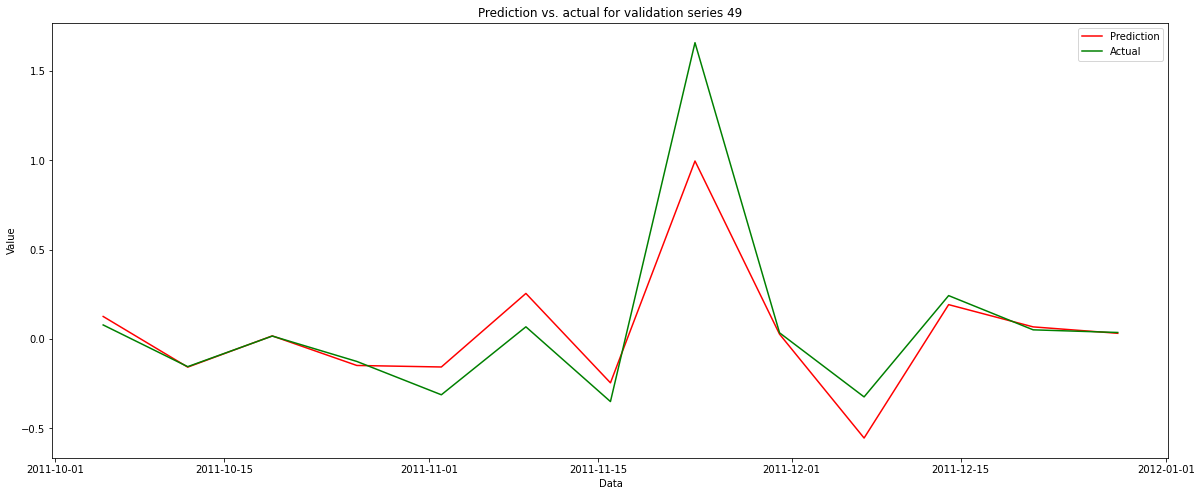

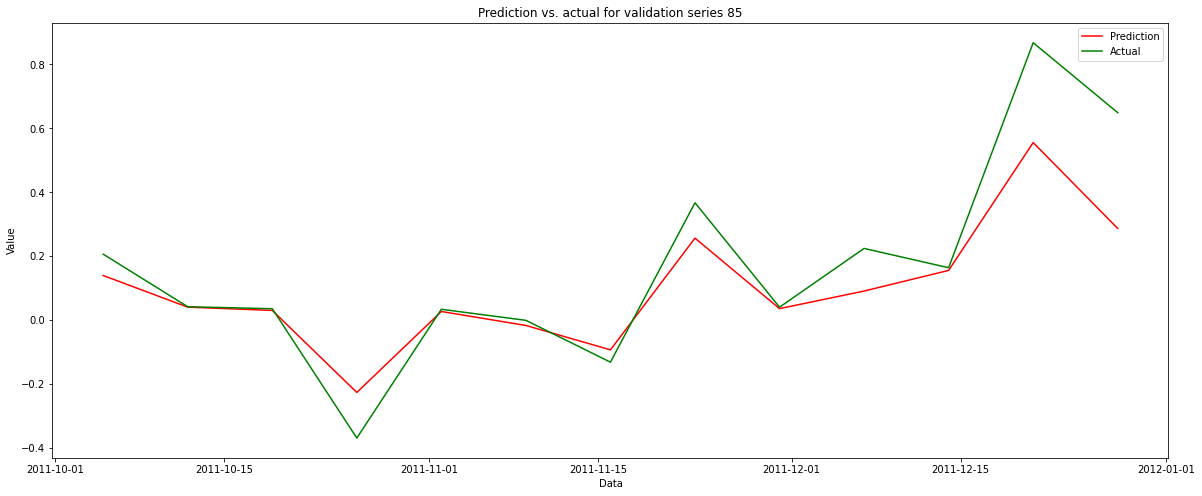

no data point for validation series 349


<Figure size 1440x576 with 0 Axes>

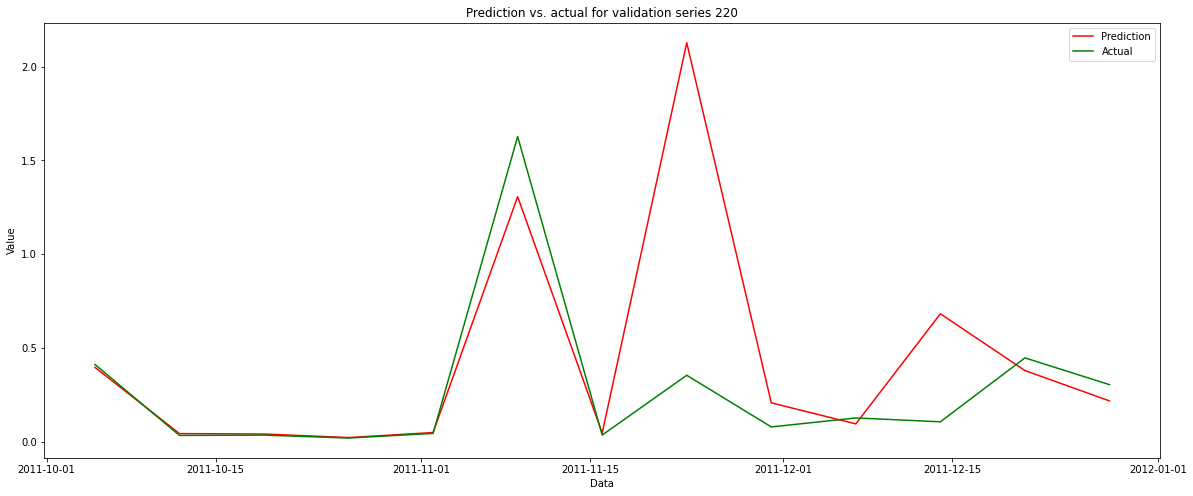

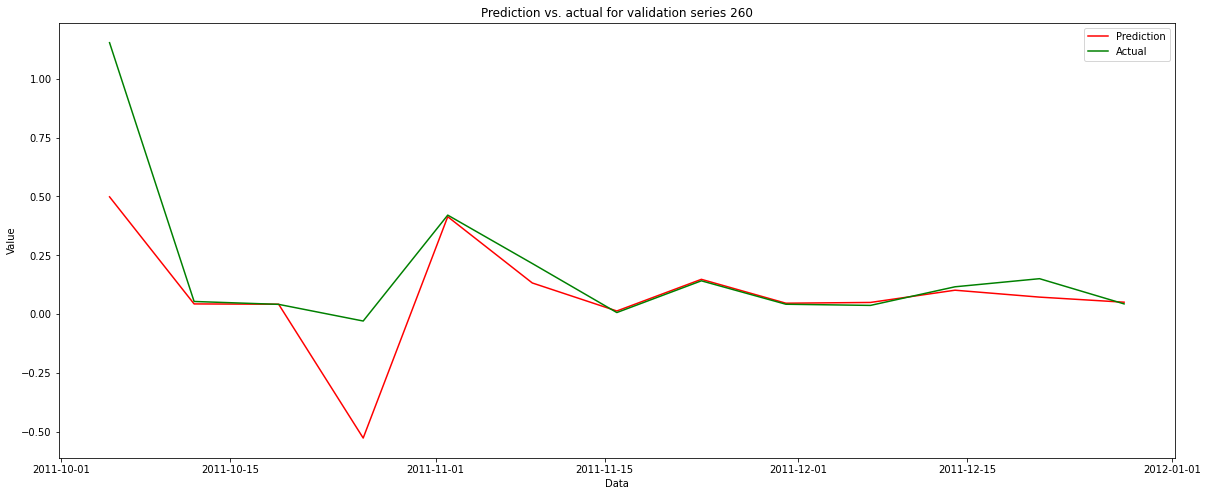

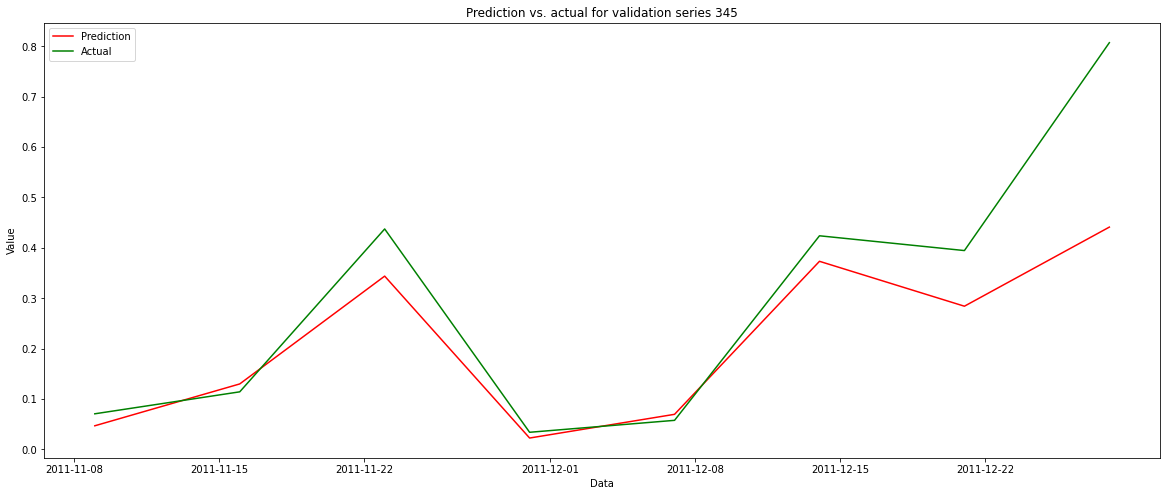

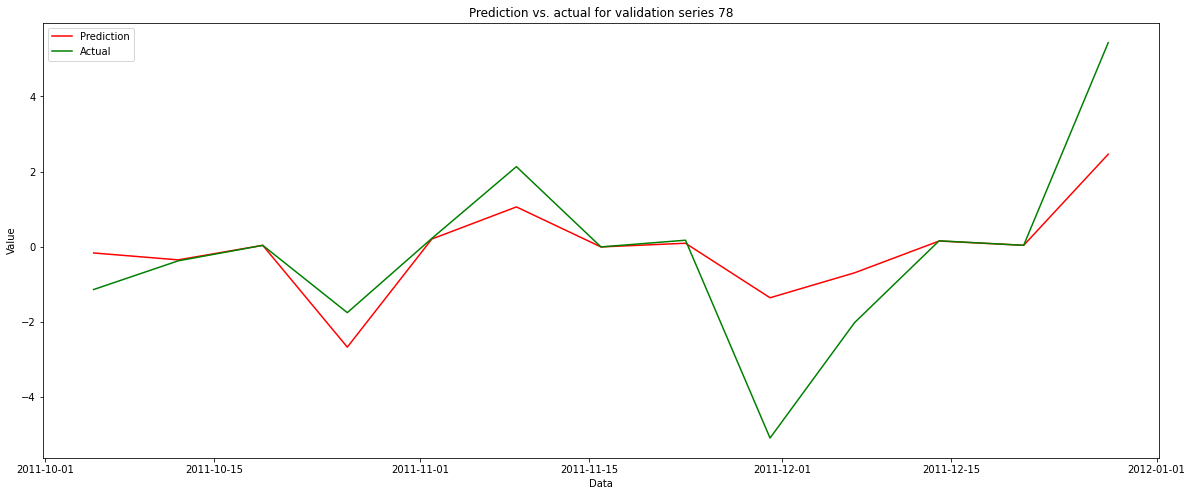

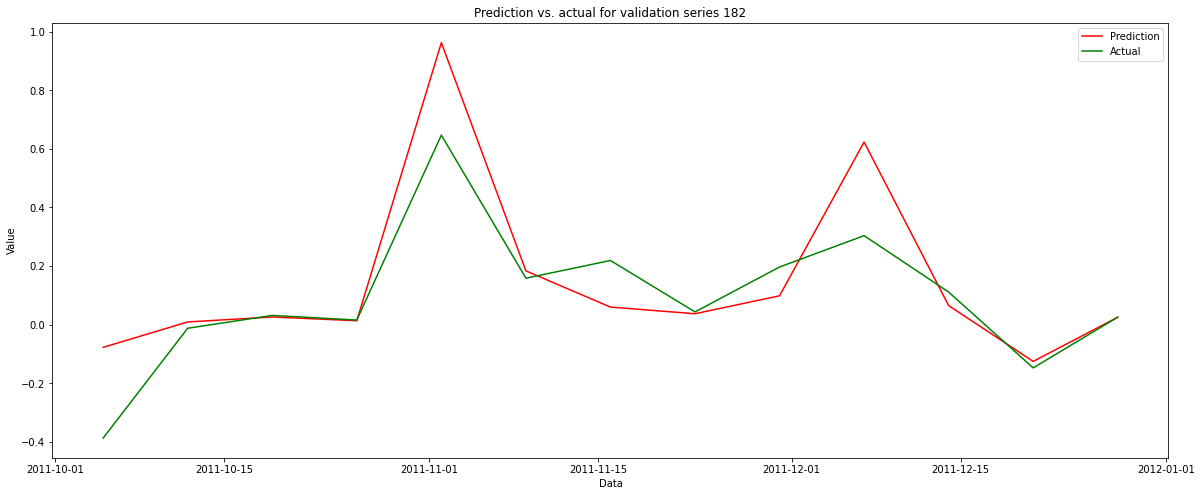

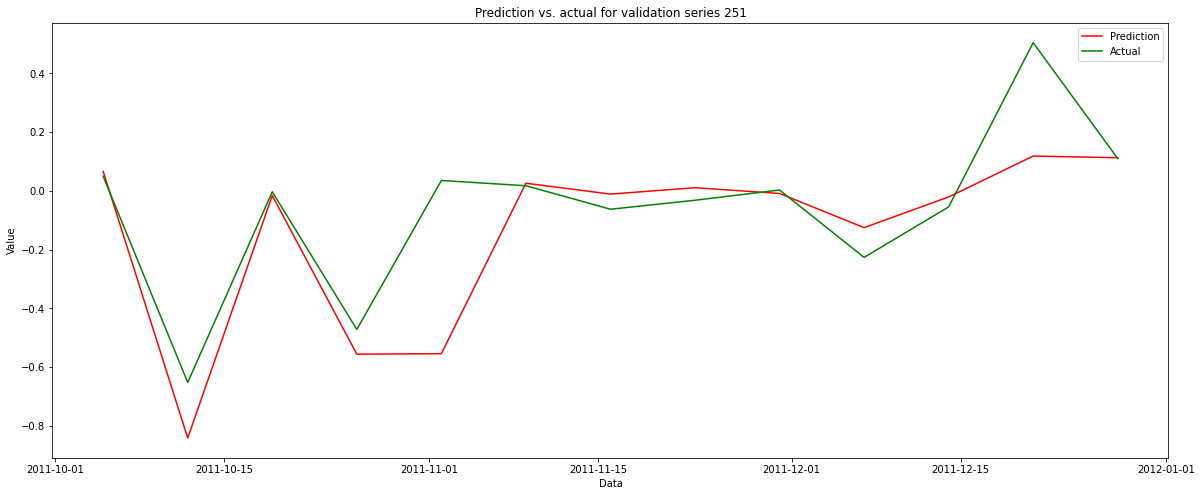

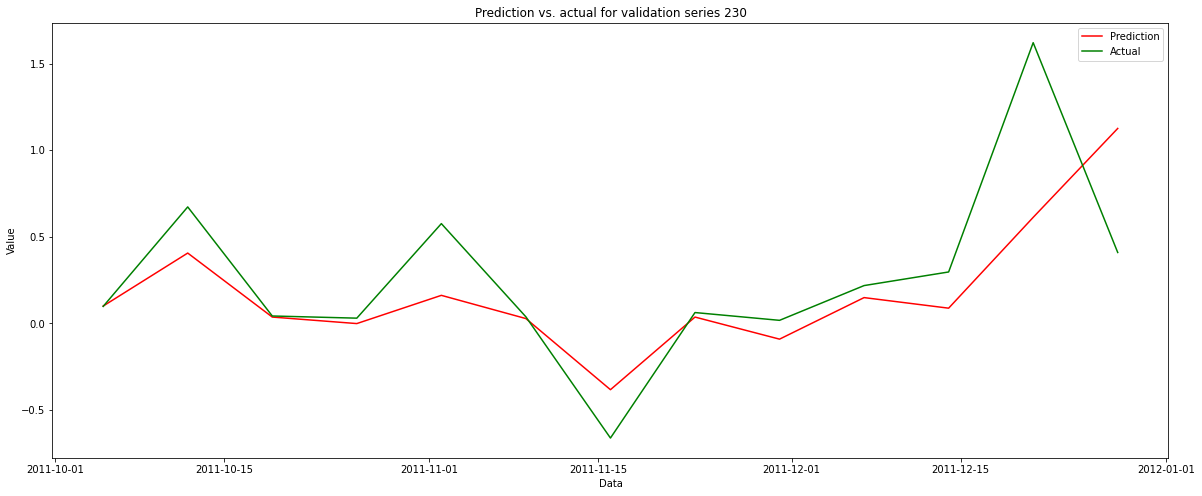

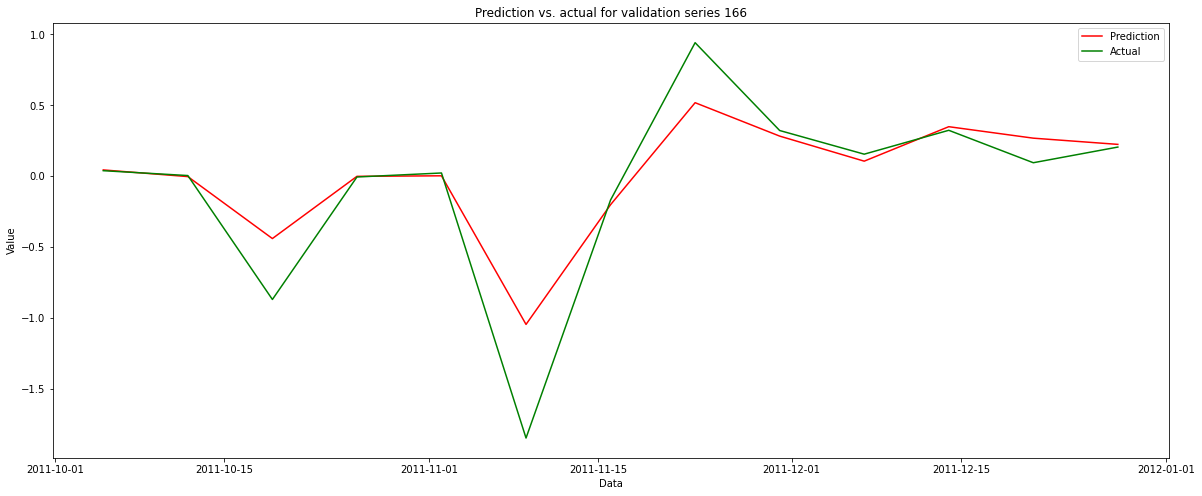

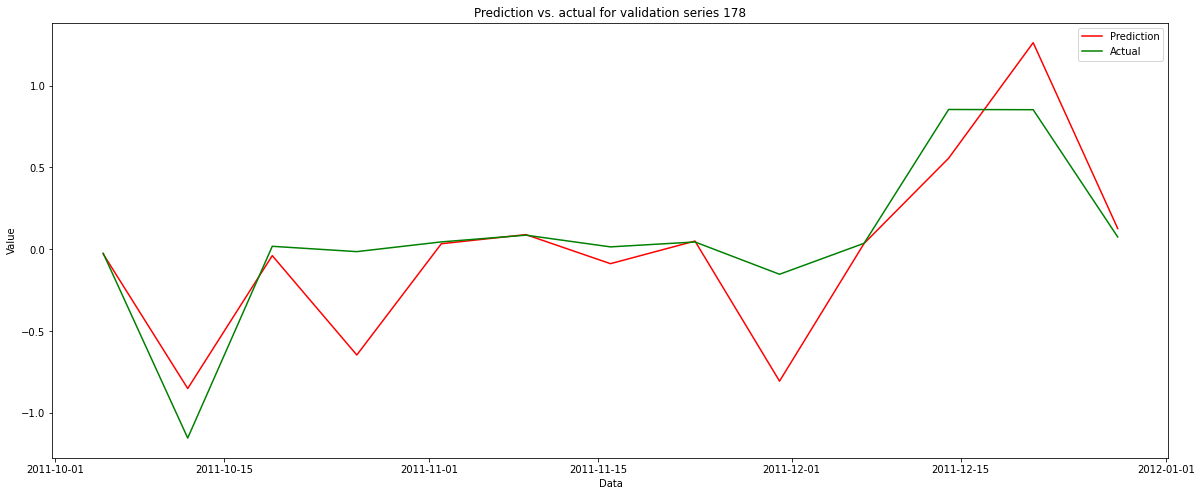

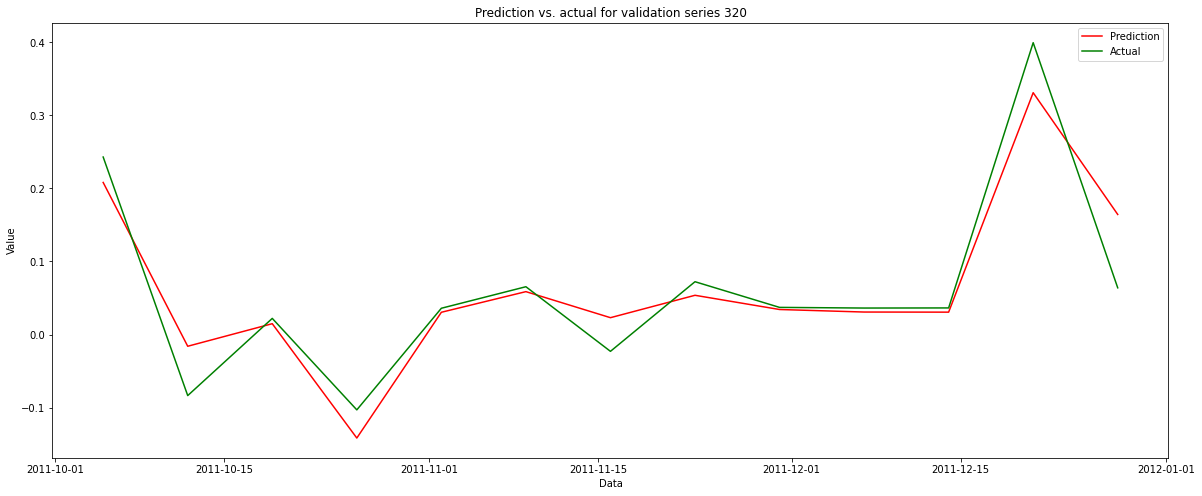

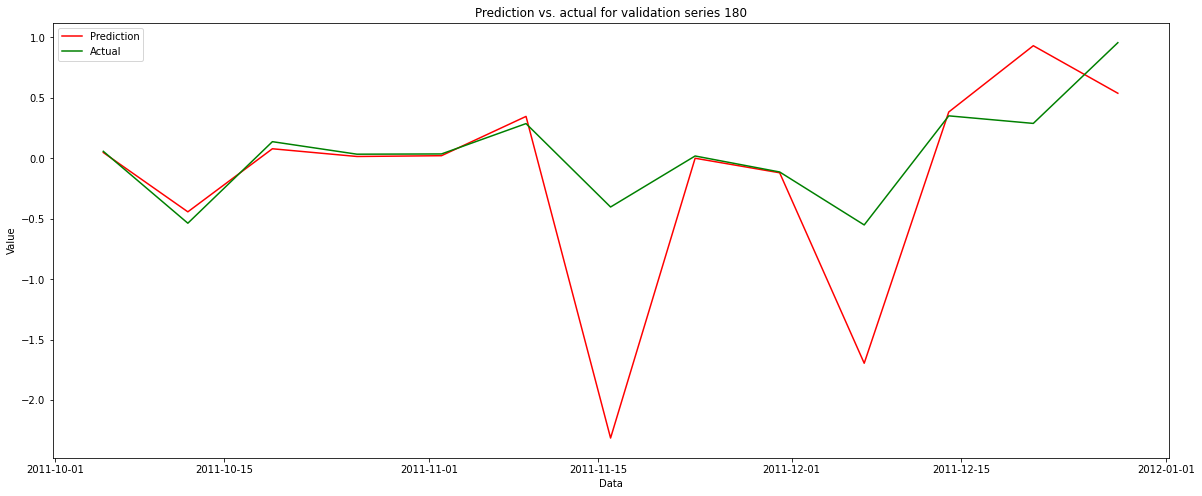

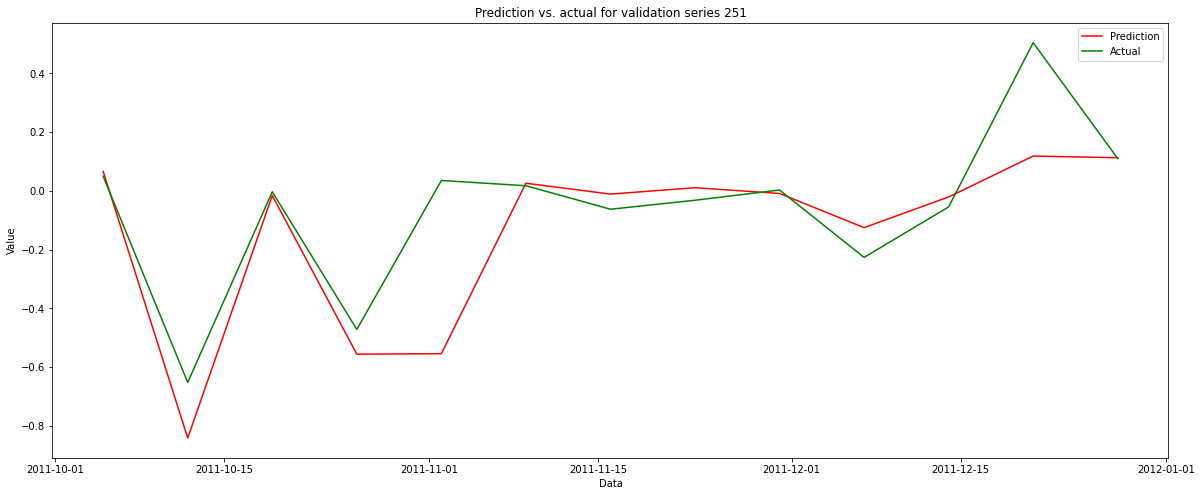

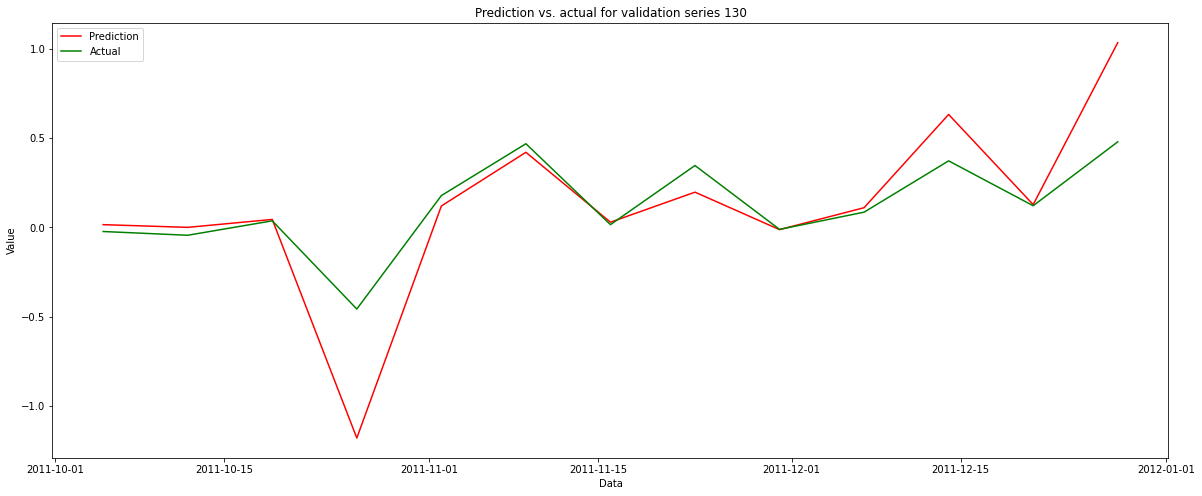

no data point for validation series 292


<Figure size 1440x576 with 0 Axes>

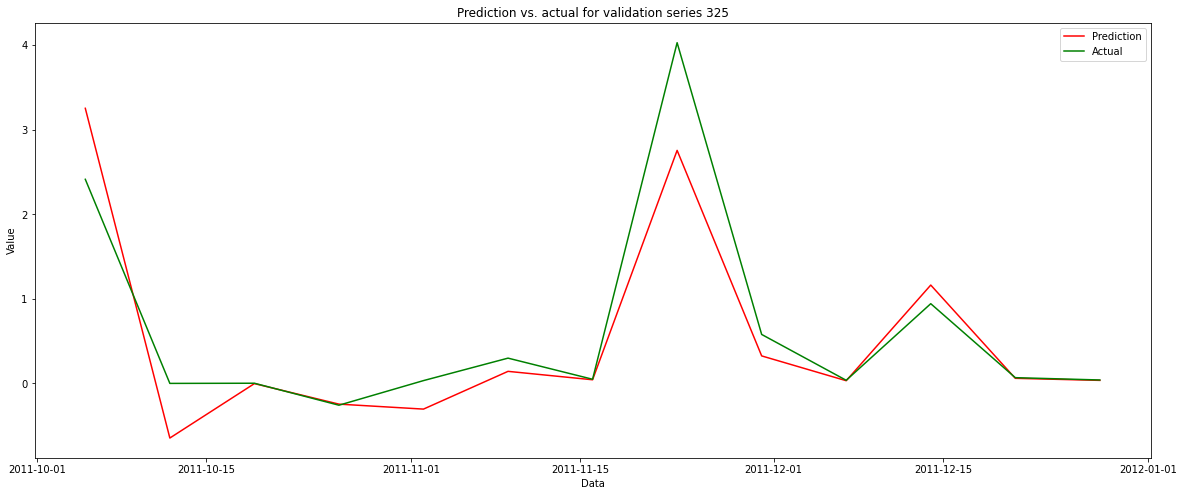

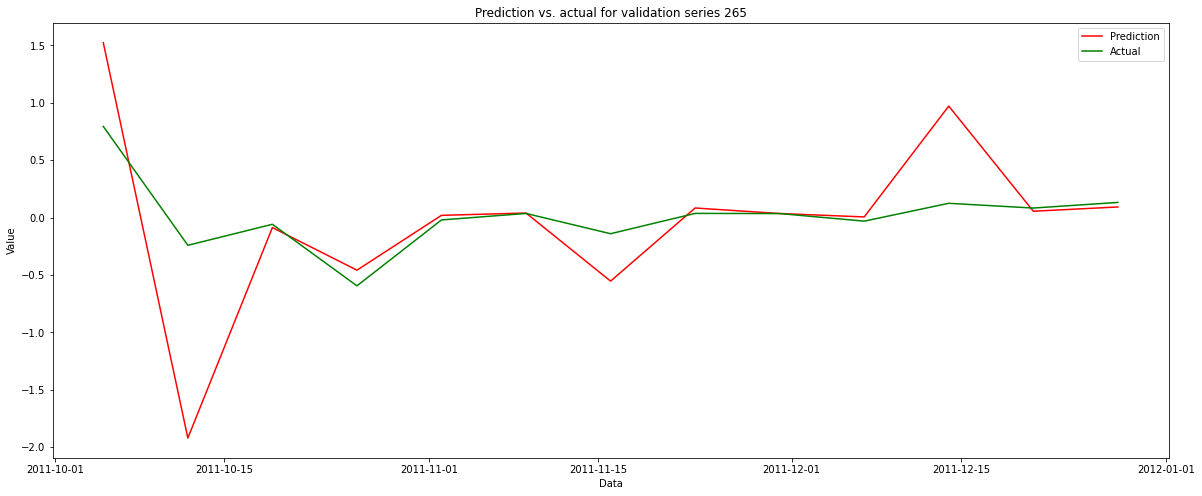

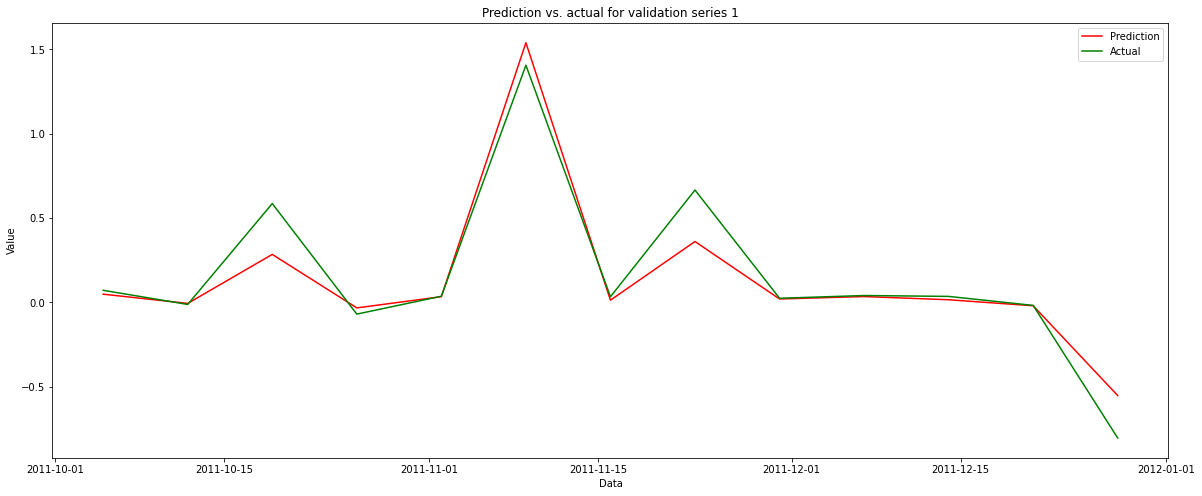

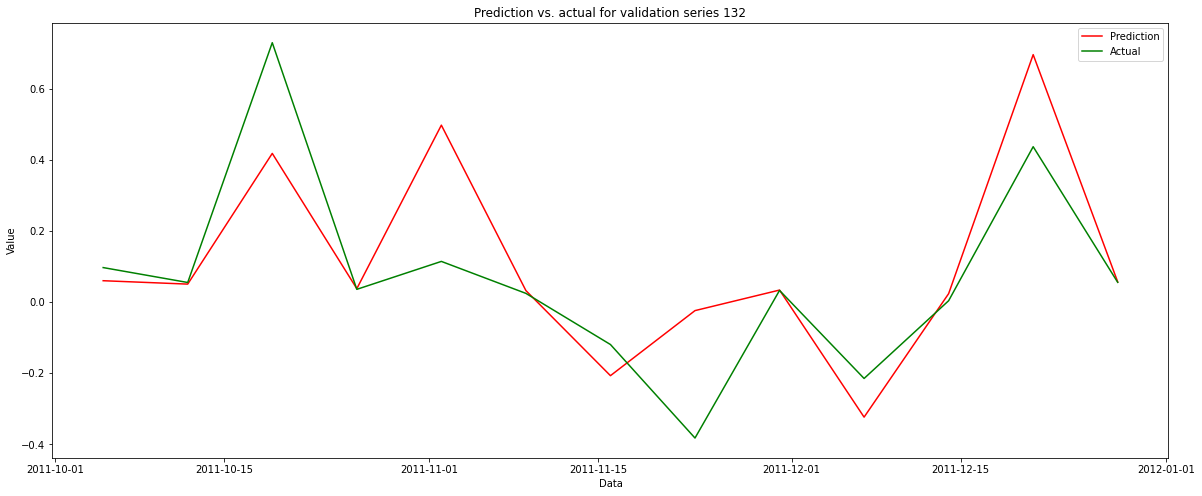

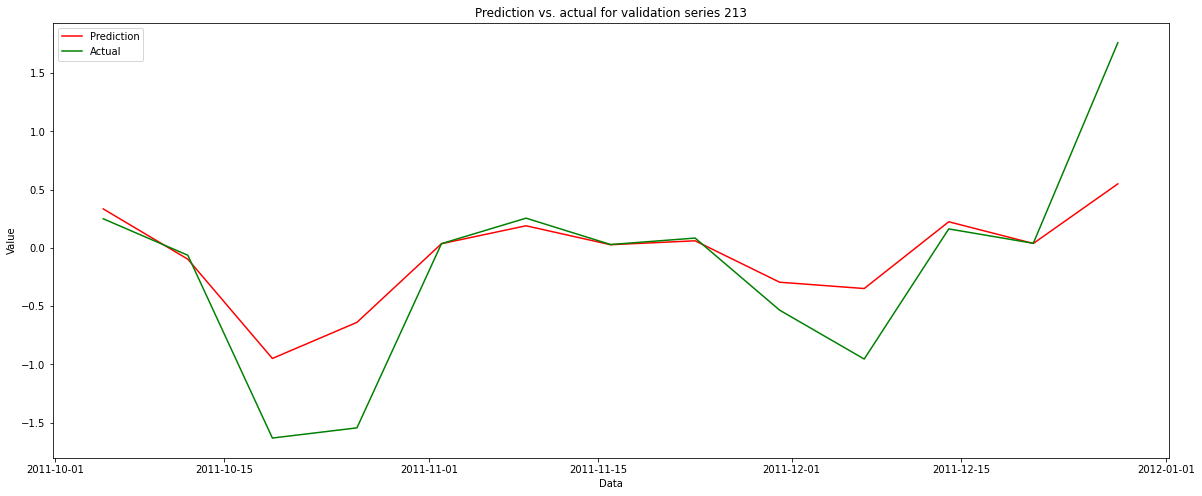

In [ ]:
def plot_random_predictions(n, model = model):

  for i in range(0,n):
    if valid_final[np.random.randint(0, len(valid_final))].shape[0] >0:
      plot_predictions(valid_final, np.random.randint(0, len(valid_final)), model = model)
      plt.show()
    else:
      plot_random_predictions(n-i)

plot_random_predictions(10)

(13, 64)


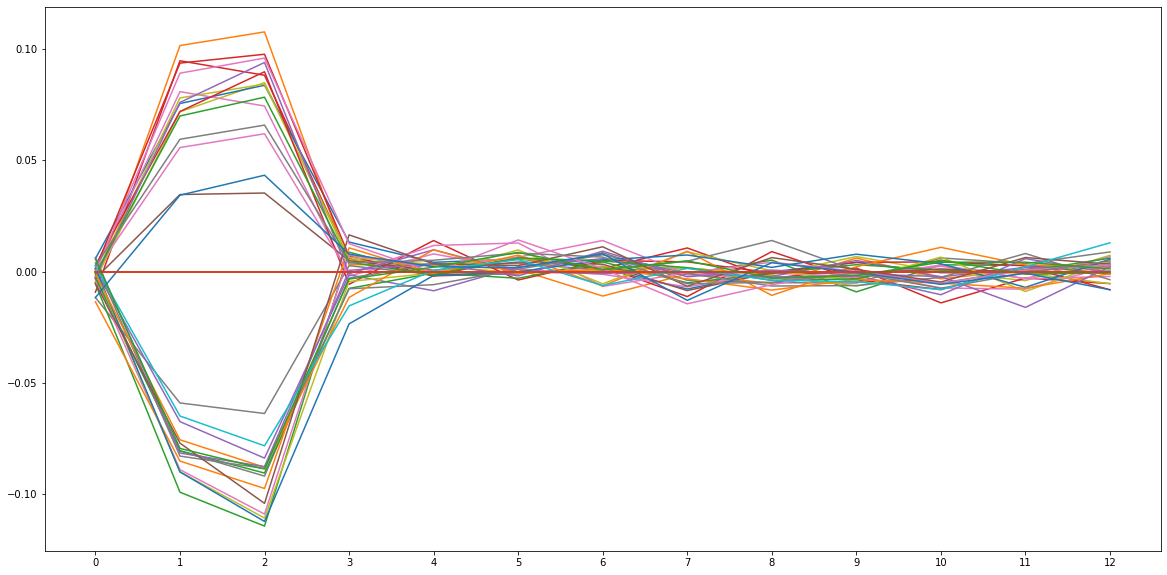

In [ ]:
x = np.squeeze(model.layers[1].get_weights()[0])
print(x.shape)
plt.figure(figsize = (20,10))
plt.xticks(range(0,x.shape[0]))
#plt.yscale('log')
plt.plot(x)

In [ ]:
train_dict_time, valid_dict_time, test_dict_time = split_to_series(data, valid_cut = '2011-06-01', drop_non_complete = True)
train_final_time, valid_final_time, test_final_time, t_mean, t_std= \
scale_and_drop_columns(train_dict_time, valid_dict_time, test_dict_time, numerical_features)

Number of series to be trained: 271
Number of time series to be validated: 271
Number of time series to be tested: 0
Number of time steps to be trained: 20054
Number of time steps to be validated: 8401
Number of time series to be tested: 0
Train_proportion: 0.7047619047619048


In [ ]:
def split_datasets(data_dict, window_size = g.window_size):
  static_data = data_dict[0].iloc[window_size:,:-1]
  targets = data_dict[0]['target'].iloc[window_size:]
  windows = data_dict[0][['target']].iloc[0:window_size].reset_index(drop = True).transpose()
  for i in range(1, len(data_dict[0])-window_size):
    window = data_dict[0][['target']].iloc[i:window_size+i].reset_index(drop = True).transpose()
    windows = pd.concat((windows, window), axis = 0)
  def make_windows(data, windows, targets, window_size = window_size):
    target = data['target'].iloc[window_size:]
    for i in range(0, len(data)-window_size):
      window = data[['target']].iloc[i:window_size+i].reset_index(drop = True).transpose()
      windows = pd.concat((windows, window), axis = 0)
    targets = pd.concat([targets, target], axis = 0)
    return windows, targets
  for i in range(1, len(data_dict)):
    static_temp = data_dict[i].iloc[window_size:,:-1]
    static_data = pd.concat([static_data, static_temp], axis = 0)
    windows, targets = make_windows(data_dict[i], windows, targets)
  return np.asarray(static_data.reset_index(drop= True)), np.asarray(windows.reset_index(drop=True)), np.asarray(targets.reset_index(drop= True))

In [ ]:
train_static, train_windows, train_targets= split_datasets(train_final_time)
valid_static, valid_windows, valid_targets = split_datasets(valid_final_time)

In [ ]:
train_static.shape, train_windows.shape, train_targets.shape, valid_static.shape, valid_windows.shape, valid_targets.shape

((15718, 13), (15718, 16), (15718,), (4065, 13), (4065, 16), (4065,))

In [ ]:
np.count_nonzero(~np.isnan(train_targets))

15718

In [ ]:
# def convert_to_tensor(data_dict, window_size = g.window_size, batch_size = g.batch_size, shuffle_buffer = 1000, shuffle = True):
#     dataset = tf.data.Dataset.from_tensor_slices(np.asarray(data_dict[0], dtype= np.float32))
#     dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
#     dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
#     dataset = dataset.map(lambda window: (window[:-1], window[-1,-1]))
#     for i in range(1, len(data_dict)):
#       dataset_tmp = tf.data.Dataset.from_tensor_slices(np.asarray(data_dict[i], dtype= np.float32))
#       dataset_tmp = dataset_tmp.window(window_size + 1, shift=1, drop_remainder=True)
#       dataset_tmp = dataset_tmp.flat_map(lambda window: window.batch(window_size + 1))
#       dataset_tmp = dataset_tmp.map(lambda window: (window[:-1], window[-1,-1]))
#       dataset = dataset.concatenate(dataset_tmp)
#     if shuffle == True:
#       dataset = dataset.shuffle(shuffle_buffer)
#     dataset = dataset.batch(batch_size).prefetch(1)
#     return dataset

In [ ]:
# train_time, train_static = convert_to_tensor(train_scaled)
# valid_time, valid_static = convert_to_tensor(valid_scaled, shuffle = False)
# test_time, test_static = convert_to_tensor(test_scaled, shuffle = False)

In [ ]:
def conv_block(input_,filter_units,kernel_size,dr):
    x = Conv1D(filters = filter_units, kernel_size = kernel_size, strides = 1,
                                                              kernel_initializer='he_normal', 
               kernel_regularizer = 'l2', padding = 'causal',activation = 'relu')(input_)
    # x = Dropout(dr)(x)
    # x = MaxPooling1D()(x)
    # x = Conv1D(filters = filter_units, kernel_size = kernel_size, strides = 1,
    #                                                           kernel_initializer='he_normal', padding = 'causal',activation = 'relu')(x)
    out = Dropout(dr)(x)
    #out = MaxPooling1D()(x)
    return out

In [ ]:
def lstm_block(input_,lstm_units, dr):
    #x = LSTM(lstm_units, return_sequences = True, dropout = dr)(input_)
    out = LSTM(lstm_units, return_sequences = False, dropout = dr, recurrent_dropout = dr, 
               kernel_regularizer='l2', recurrent_regularizer='l2')(input_)
    return(out)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 static (InputLayer)            [(None, 13)]         0           []                               
                                                                                                  
 dense (Dense)                  (None, 64)           896         ['static[0][0]']                 
                                                                                                  
 dropout (Dropout)              (None, 64)           0           ['dense[0][0]']                  
                                                                                                  
 activation (Activation)        (None, 64)           0           ['dropout[0][0]']                
                                                                                              

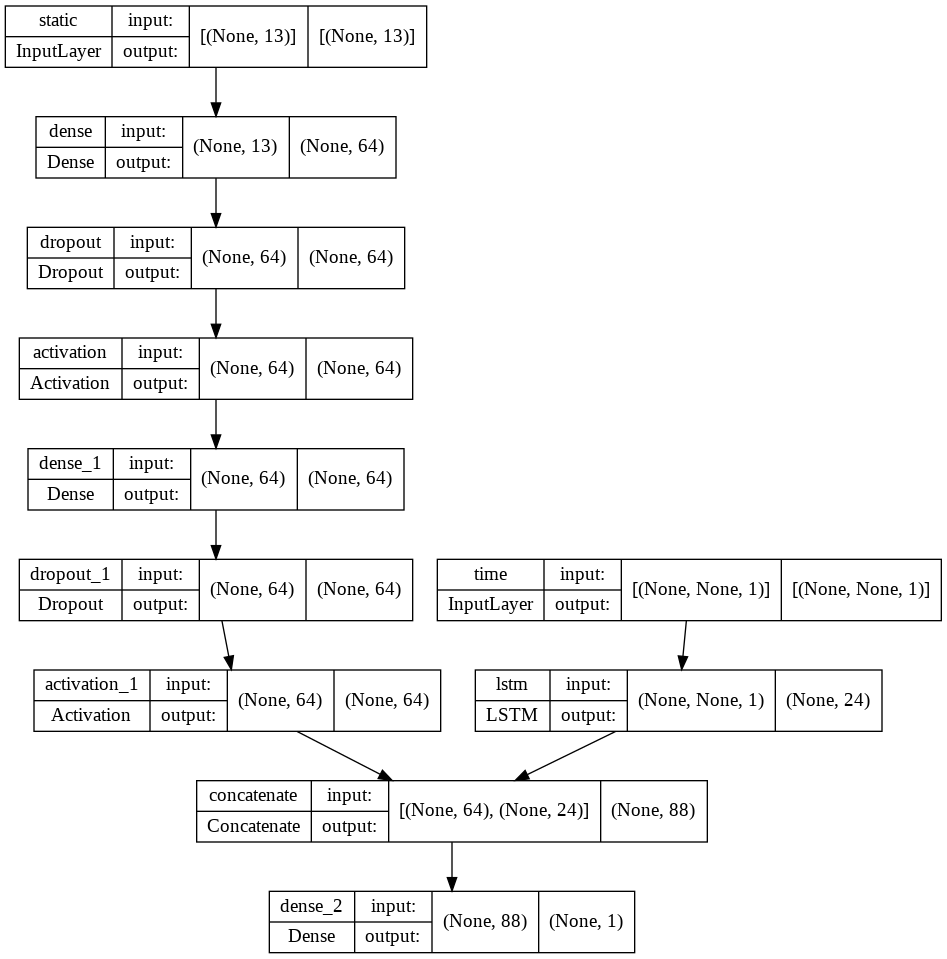

In [ ]:
K.clear_session()

def create_time_model(filter_units = 64, lstm_units = 24, kernel_size = 4, dense_units = 64, dr = .2 ):
    input0 = Input(shape = (train_static.shape[1],), name = 'static')
    input1 = Input(shape = (None, 1), name = 'time')
    #x = conv_block(input1,filter_units, kernel_size, dr)                                                            
    x = lstm_block(input1, lstm_units, dr)
    
    
    y = dense_block(input0, dense_units, dr)
    #x = Flatten()(x)
    x = Concatenate()([y, x])
    out = Dense(1)(x)
    model = Model(inputs = [input0,input1], outputs = out)

    return model
nadam = tf.keras.optimizers.Nadam(learning_rate=.001)
rmsprop = tf.keras.optimizers.RMSprop(learning_rate = .001, momentum=.9)
time_model = create_time_model()
time_model.compile(loss = 'mae', optimizer = 'adam', metrics = ['mae',create_mape(), create_smape()])
time_model.summary()
tf.keras.utils.plot_model(time_model, show_shapes=True)

In [ ]:
early_stopping = EarlyStopping(patience = 5, restore_best_weights= True)
history = time_model.fit(x = {'static':train_static, 'time':train_windows}, y= train_targets, shuffle = True,
                    validation_data = [{'static':valid_static, 'time':valid_windows}, valid_targets], 
                    batch_size = g.batch_size, epochs = 100, callbacks = early_stopping)

Epoch 1/100
492/492 [==============================] - 12s 17ms/step - loss: 1.4753 - mae: 0.2851 - mape: 33.9297 - smape: 52.7045 - val_loss: 0.7315 - val_mae: 0.3349 - val_mape: 27.8510 - val_smape: 38.4103
Epoch 2/100
492/492 [==============================] - 8s 16ms/step - loss: 0.4273 - mae: 0.2333 - mape: 24.8036 - smape: 36.0231 - val_loss: 0.4092 - val_mae: 0.3280 - val_mape: 27.0556 - val_smape: 36.3073
Epoch 3/100
492/492 [==============================] - 8s 16ms/step - loss: 0.2732 - mae: 0.2237 - mape: 23.6553 - smape: 33.6969 - val_loss: 0.3566 - val_mae: 0.3232 - val_mape: 28.2773 - val_smape: 36.3322
Epoch 4/100
492/492 [==============================] - 8s 17ms/step - loss: 0.2492 - mae: 0.2227 - mape: 23.5379 - smape: 33.2401 - val_loss: 0.3474 - val_mae: 0.3245 - val_mape: 27.4619 - val_smape: 35.8323
Epoch 5/100
492/492 [==============================] - 8s 16ms/step - loss: 0.2428 - mae: 0.2215 - mape: 23.4670 - smape: 33.0044 - val_loss: 0.3448 - val_mae: 0.3249 

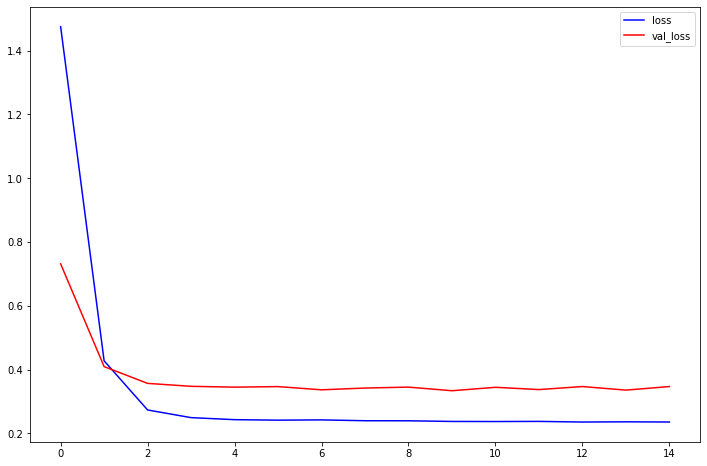

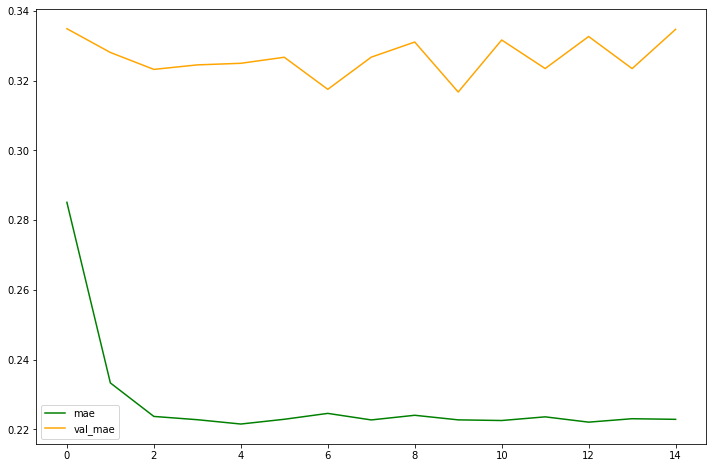

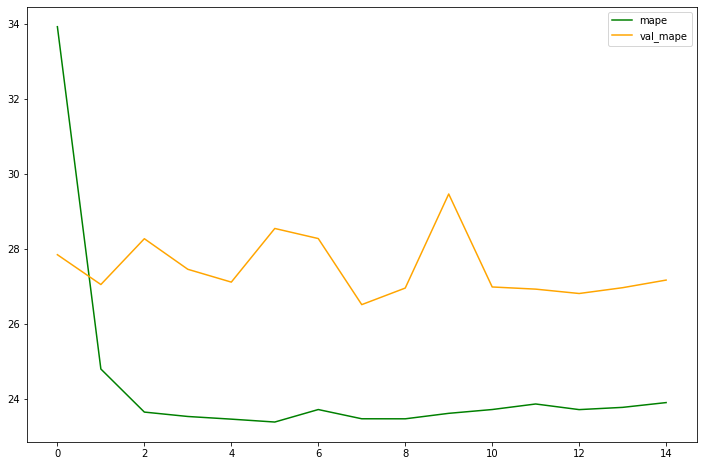

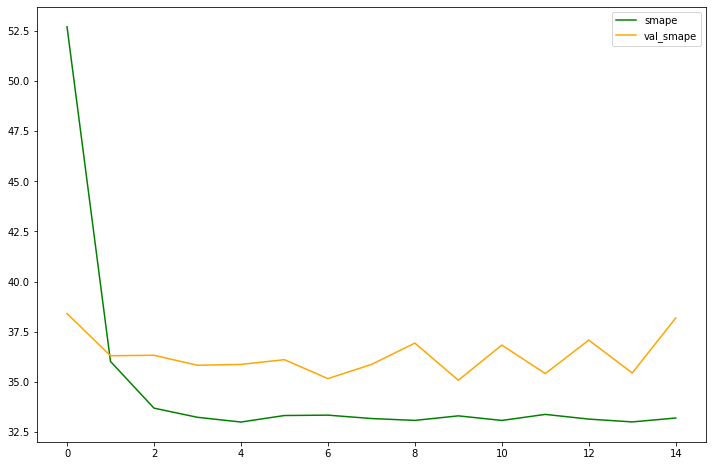

128/128 [==============================] - 1s 4ms/step - loss: 0.3336 - mae: 0.3167 - mape: 29.4695 - smape: 35.0876


[0.3335670828819275, 0.31670644879341125, 29.46954345703125, 35.08757019042969]

In [ ]:
plot_model_perf(history, ['mae','mape','smape'])
time_model.evaluate({'static':valid_static, 'time':valid_windows}, valid_targets)

(13, 64)


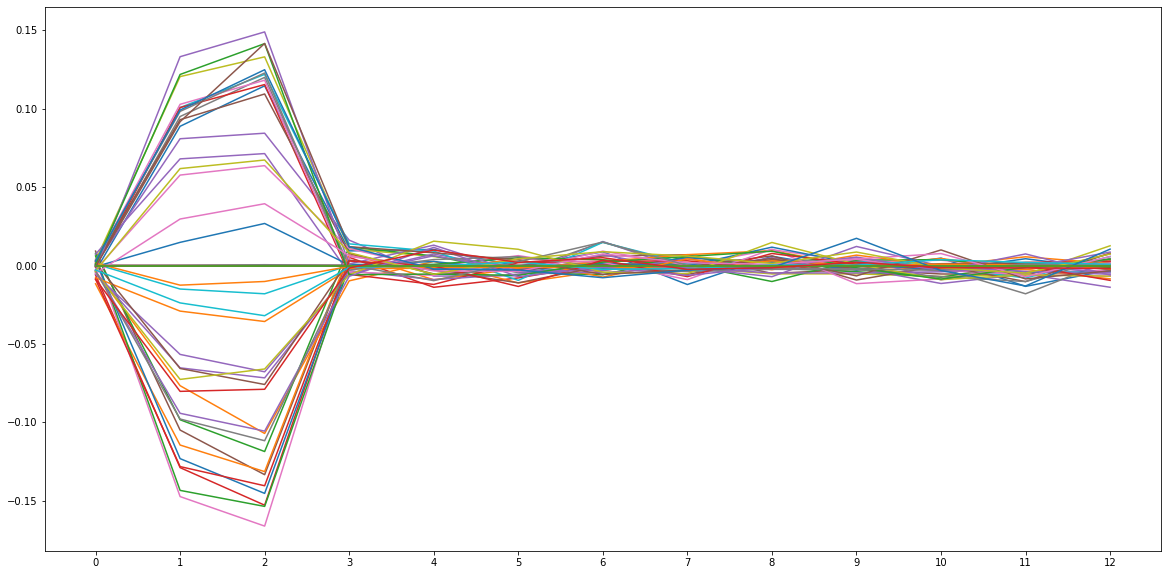

In [ ]:
x = np.squeeze(time_model.layers[1].get_weights()[0])
print(x.shape)
plt.figure(figsize = (20,10))
plt.xticks(range(0,x.shape[0]))
#plt.yscale('log')
plt.plot(x)

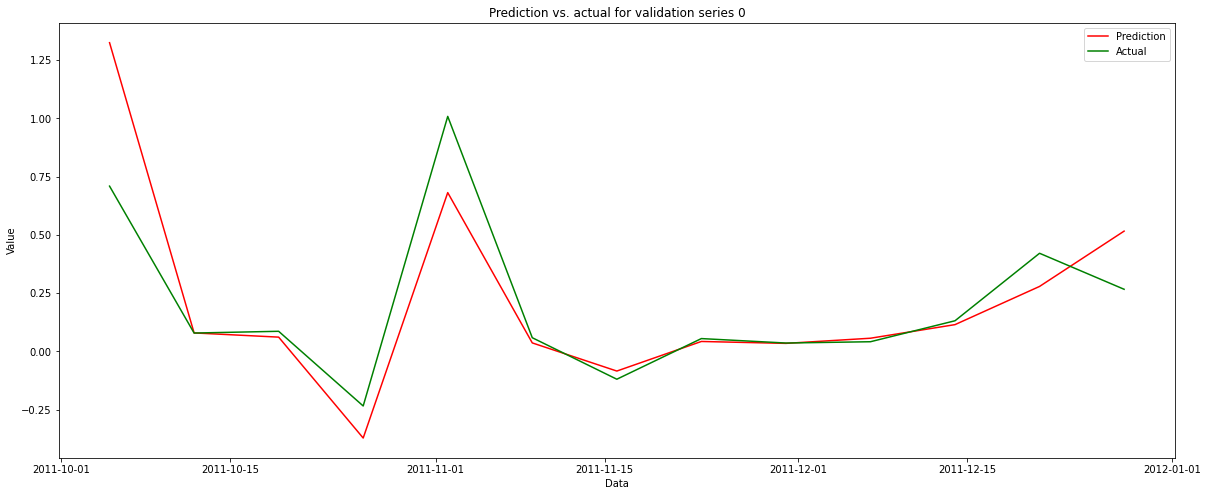

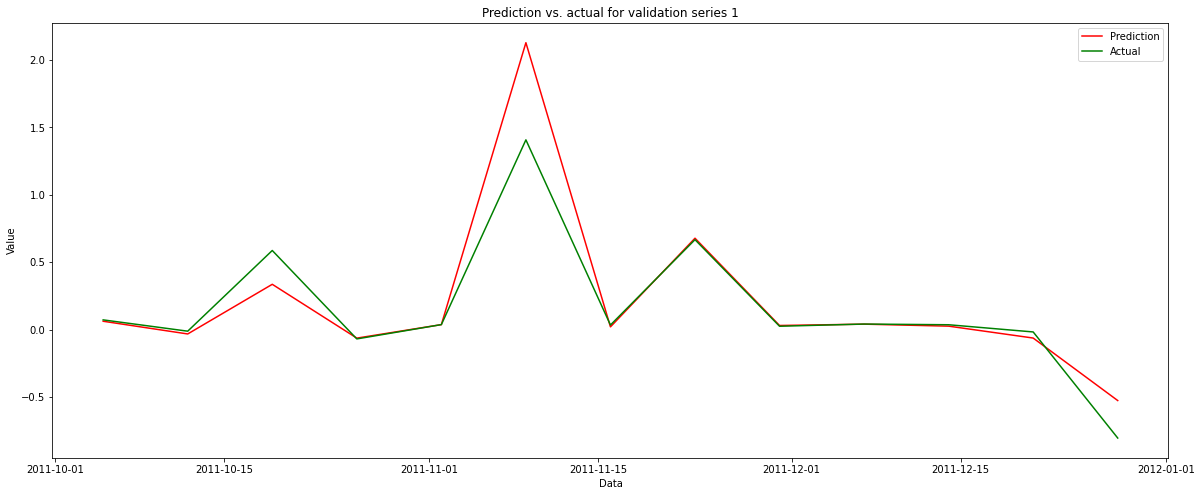

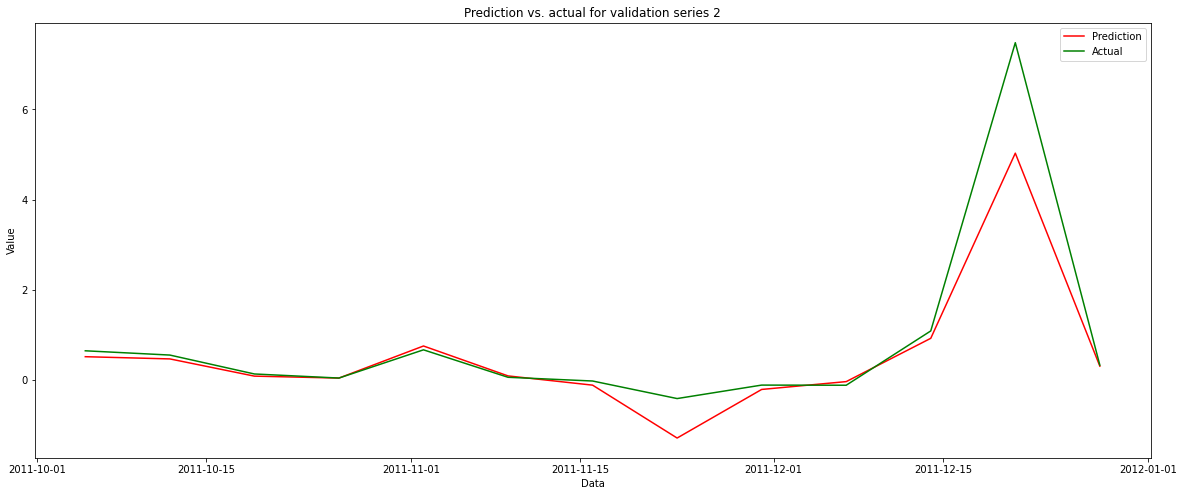

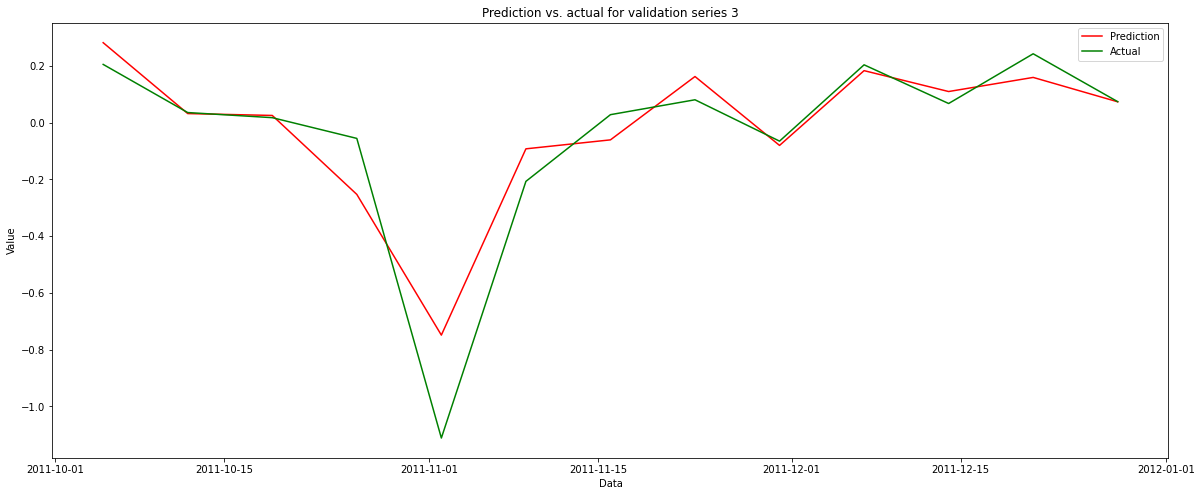

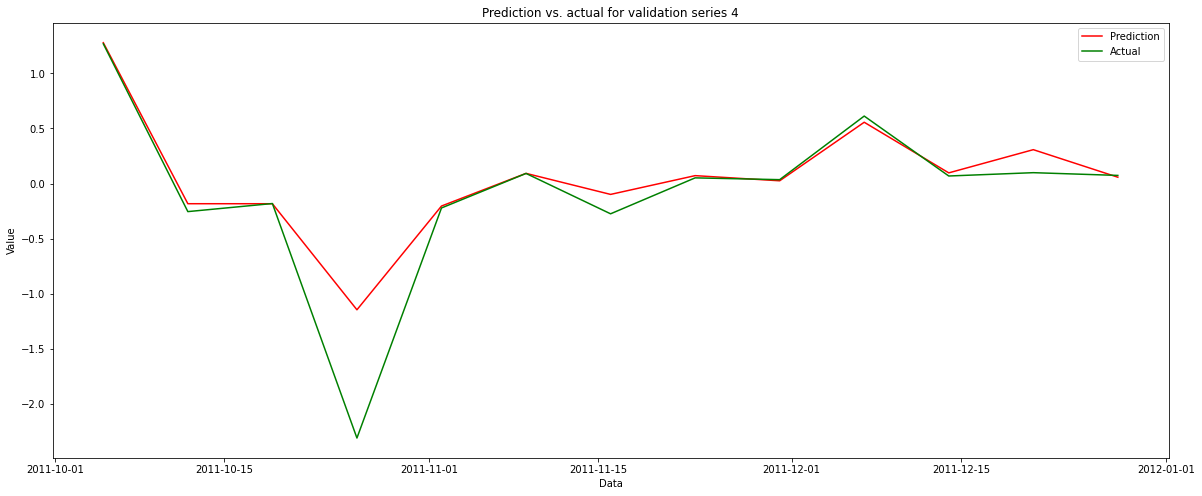

In [ ]:
for i in range(0, 5):
  plot_predictions(valid_final, i, model = randforest_test)

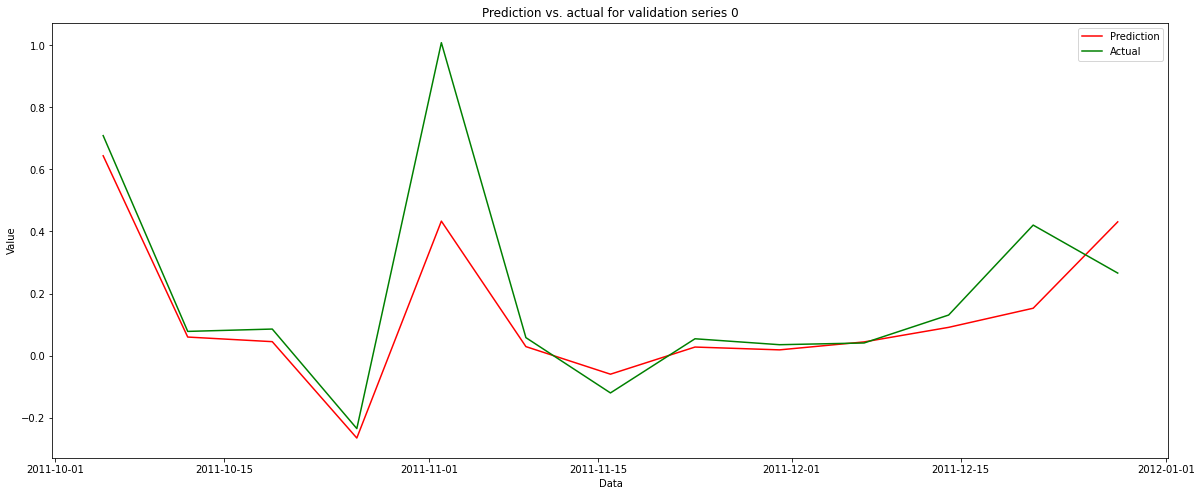

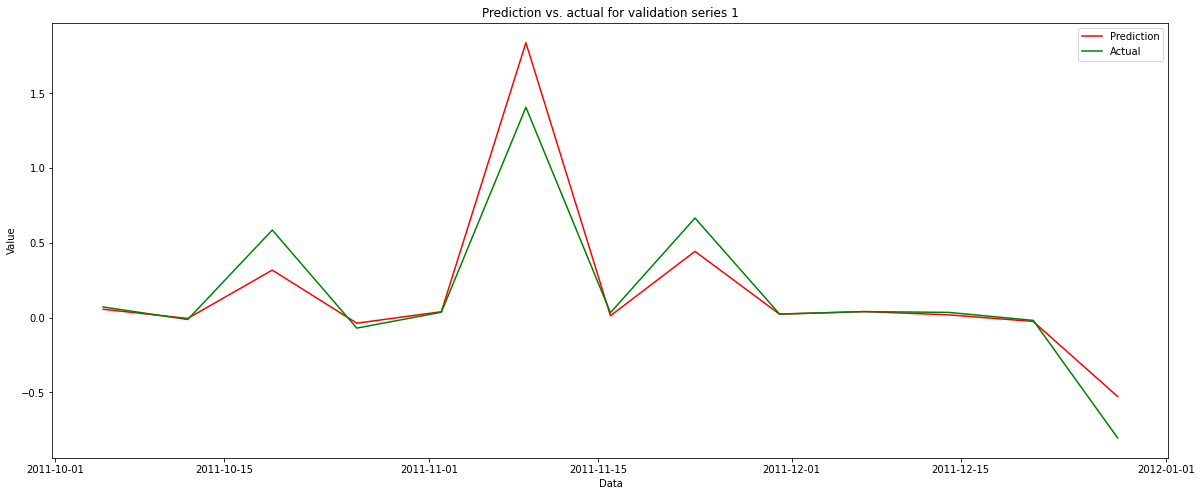

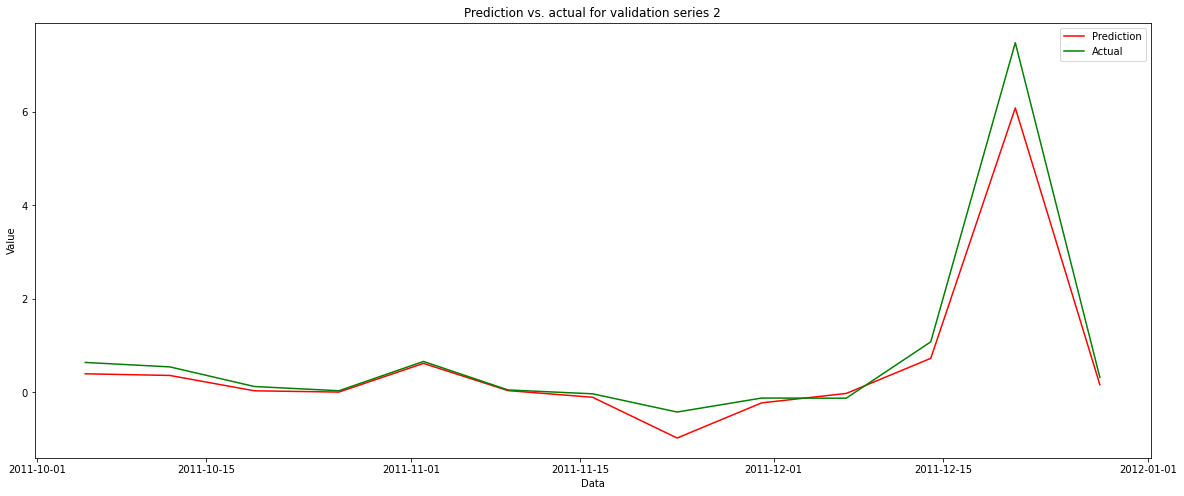

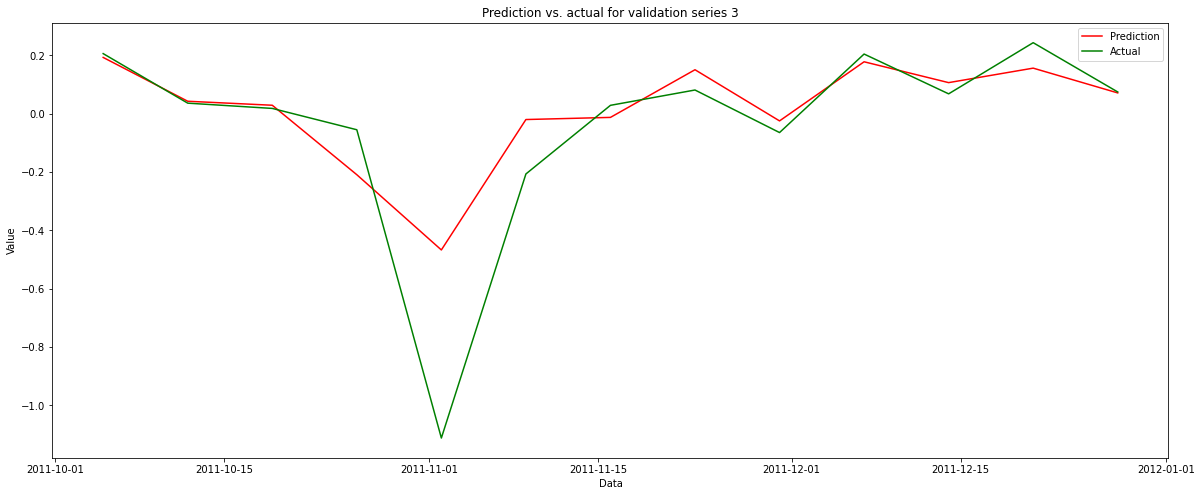

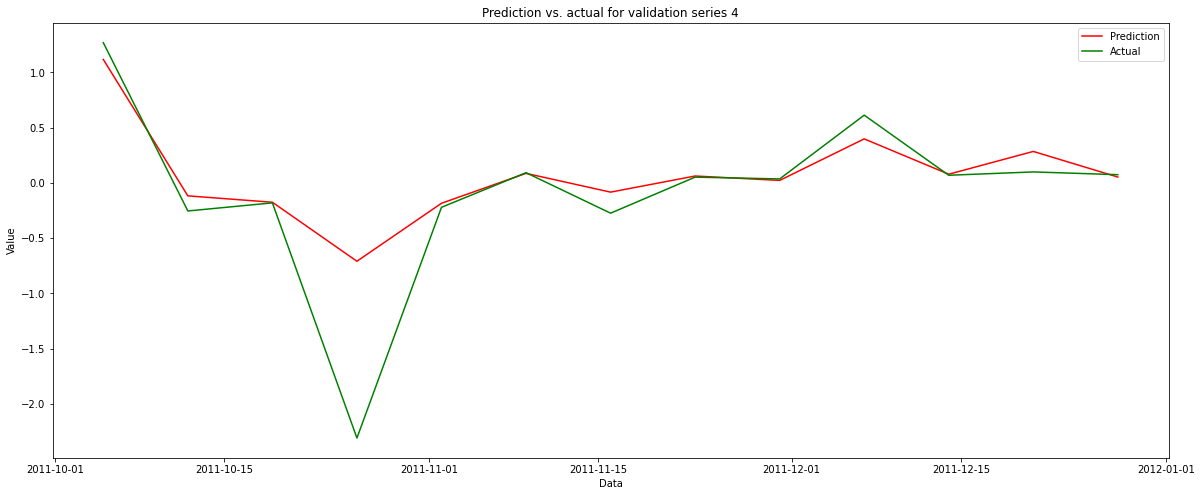

In [ ]:
lin_reg = LinearRegression()
lin_reg.fit(x_train, y_train)
for i in range(0, 5):
  plot_predictions(valid_final, i, model = lin_reg)